<a href="https://colab.research.google.com/github/beyzaturku/runway_detection_and_segmentation/blob/main/polinom_fit_runway_line.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install opencv-contrib-python scikit-image scikit-learn matplotlib scipy

Scikit-image mevcut
Orijinal mask boyutu: (1024, 1024)
Mask değer aralığı: 0 - 255
İkili mask beyaz piksel sayısı: 6887
Opening sonrası beyaz piksel sayısı: 6879
Closing sonrası beyaz piksel sayısı: 6880
Bulunan bileşen sayısı: 2
En büyük bileşen alanı: 6880 piksel
Skeleton öncesi beyaz piksel sayısı: 6880
Scikit-image skeleton başarılı, piksel sayısı: 172
Bulunan skeleton piksel sayısı: 172
Filtrelenmiş nokta sayısı: 58


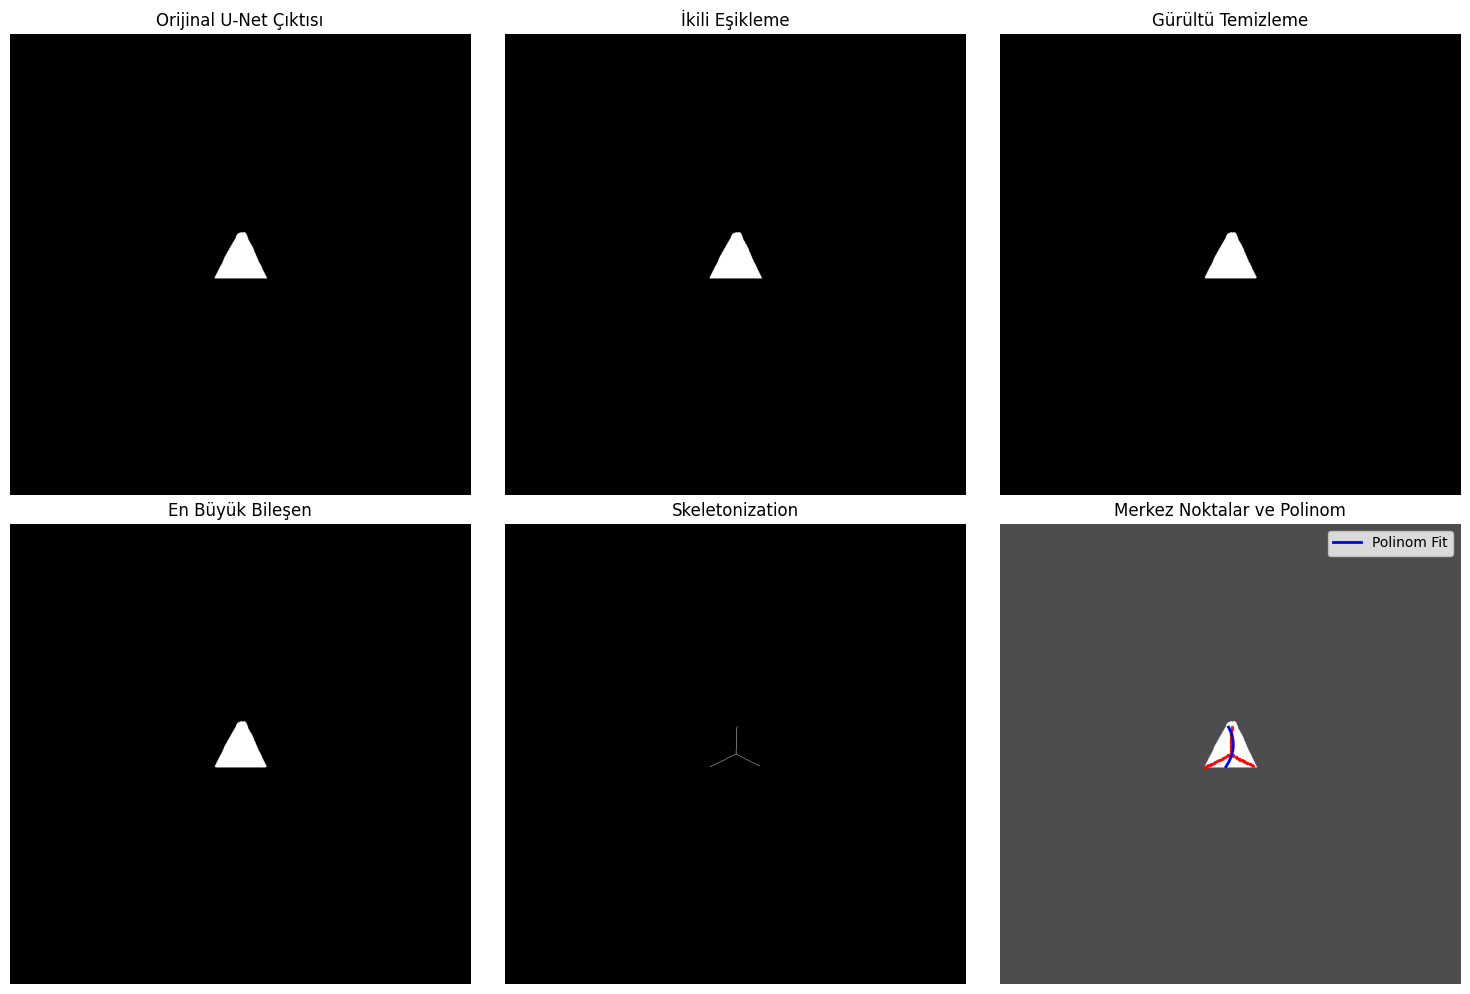

Çıkarılan merkez nokta sayısı: 58
Polinom fit başarılı!
Fit edilen nokta sayısı: 100
Uçak-pist merkez hattı sapması: 234.96 piksel


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def preprocess_runway_mask(mask_path, visualization=True):
    """
    U-Net çıktısından pist merkez hattı çıkarma için ön işlemler
    """
    # 1. Maskeyi yükle
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise ValueError(f"Mask dosyası yüklenemedi: {mask_path}")

    print(f"Orijinal mask boyutu: {mask.shape}")
    print(f"Mask değer aralığı: {mask.min()} - {mask.max()}")

    # 2. Eşikleme (threshold) - U-Net çıktısı genelde 0-255 arası
    if mask.max() > 1:
        # 0-255 arası değerler varsa normalize et
        mask_binary = (mask > 127).astype(np.uint8) * 255
    else:
        # Zaten 0-1 arası ise
        mask_binary = (mask > 0.5).astype(np.uint8) * 255

    print(f"İkili mask beyaz piksel sayısı: {np.sum(mask_binary > 0)}")

    # 3. Gürültü temizleme - Morfotojik işlemler
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

    # Açma işlemi (opening) - küçük gürültüleri temizler
    mask_opened = cv2.morphologyEx(mask_binary, cv2.MORPH_OPEN, kernel)
    print(f"Opening sonrası beyaz piksel sayısı: {np.sum(mask_opened > 0)}")

    # Kapama işlemi (closing) - boşlukları doldurur
    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    mask_cleaned = cv2.morphologyEx(mask_opened, cv2.MORPH_CLOSE, kernel_close)
    print(f"Closing sonrası beyaz piksel sayısı: {np.sum(mask_cleaned > 0)}")

    # 4. En büyük bağlı bileşeni bul (en büyük pist alanını seç)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_cleaned)

    print(f"Bulunan bileşen sayısı: {num_labels}")

    if num_labels <= 1:
        print("Tek bileşen bulundu, orijinal mask kullanılıyor...")
        mask_largest = mask_cleaned
    else:
        # En büyük bileşeni seç (background hariç)
        largest_component_idx = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1
        mask_largest = (labels == largest_component_idx).astype(np.uint8) * 255
        print(f"En büyük bileşen alanı: {stats[largest_component_idx, cv2.CC_STAT_AREA]} piksel")

    # 5. Mask çok ince ise dilate et
    if np.sum(mask_largest > 0) < 1000:  # Çok az piksel varsa
        print("Mask çok ince, genişletiliyor...")
        dilate_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
        mask_largest = cv2.dilate(mask_largest, dilate_kernel, iterations=2)

    # 6. Skeletonization - merkez hattı çıkarma
    skeleton = skeletonize_mask(mask_largest)

    # 7. Merkez noktalarını çıkar
    centerline_points = extract_centerline_points(skeleton)

    if visualization:
        visualize_preprocessing_steps(mask, mask_binary, mask_cleaned, mask_largest, skeleton, centerline_points)

    return mask_largest, skeleton, centerline_points

def skeletonize_mask(mask):
    """
    Maskeyi skeletonize ederek merkez hattını çıkarır
    """
    mask_binary = (mask > 0).astype(np.uint8)

    print(f"Skeleton öncesi beyaz piksel sayısı: {np.sum(mask_binary)}")

    # Önce scikit-image ile dene
    try:
        from skimage.morphology import skeletonize
        skeleton_skimage = skeletonize(mask_binary > 0).astype(np.uint8) * 255

        if np.sum(skeleton_skimage) > 0:
            print(f"Scikit-image skeleton başarılı, piksel sayısı: {np.sum(skeleton_skimage > 0)}")
            return skeleton_skimage
    except ImportError:
        print("Scikit-image bulunamadı, OpenCV ile devam ediliyor...")

    # OpenCV thinning dene
    try:
        skeleton_cv = cv2.ximgproc.thinning(mask_binary)
        if np.sum(skeleton_cv) > 0:
            print(f"OpenCV skeleton başarılı, piksel sayısı: {np.sum(skeleton_cv > 0)}")
            return skeleton_cv
    except AttributeError:
        print("OpenCV contrib thinning bulunamadı...")

    # Manuel skeleton algoritması (fallback)
    print("Manuel skeleton algoritması kullanılıyor...")
    skeleton_manual = manual_skeletonize(mask_binary)
    return skeleton_manual

def manual_skeletonize(binary_mask):
    """
    Manuel skeleton algoritması (fallback)
    """
    # Mesafe transform ile merkez hattı bulma
    dist_transform = cv2.distanceTransform(binary_mask, cv2.DIST_L2, 5)

    # Mesafe transform'un maksimum değerlerini bul
    max_dist = np.max(dist_transform)
    threshold = max_dist * 0.7  # %70'ini al

    skeleton = (dist_transform > threshold).astype(np.uint8) * 255

    # Çok kalın ise erosion uygula
    if np.sum(skeleton > 0) > binary_mask.shape[0]:  # Çok fazla piksel varsa
        kernel = np.ones((3,3), np.uint8)
        skeleton = cv2.erode(skeleton, kernel, iterations=1)

    print(f"Manuel skeleton piksel sayısı: {np.sum(skeleton > 0)}")
    return skeleton

def extract_centerline_points(skeleton):
    """
    Skeleton'dan merkez hat noktalarını çıkarır
    """
    # Skeleton piksellerinin koordinatlarını bul
    y_coords, x_coords = np.where(skeleton > 0)

    print(f"Bulunan skeleton piksel sayısı: {len(x_coords)}")

    if len(x_coords) == 0:
        print("Skeleton'da hiç piksel bulunamadı!")
        return np.array([])

    # Alternatif nokta çıkarma yöntemi - kontur tabanlı
    if len(x_coords) < 10:  # Çok az nokta varsa kontur dene
        print("Az nokta var, kontur tabanlı çıkarma deneniyor...")
        return extract_points_from_contour(skeleton)

    # Noktaları sırala (y koordinatına göre - pistin uzunluğu boyunca)
    sorted_indices = np.argsort(y_coords)
    x_sorted = x_coords[sorted_indices]
    y_sorted = y_coords[sorted_indices]

    # Çok yakın noktaları filtrele (gürültü temizleme)
    points = []
    min_distance = max(3, len(x_sorted) // 50)  # Adaptif mesafe

    for i in range(0, len(x_sorted), min_distance):
        if i < len(x_sorted):
            points.append((x_sorted[i], y_sorted[i]))

    print(f"Filtrelenmiş nokta sayısı: {len(points)}")
    return np.array(points)

def extract_points_from_contour(skeleton):
    """
    Skeleton'dan kontur tabanlı nokta çıkarma (alternatif yöntem)
    """
    # Orijinal maskeye geri dön ve konturları bul
    contours, _ = cv2.findContours(skeleton, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        print("Kontur bulunamadı!")
        return np.array([])

    # En uzun konturu seç
    longest_contour = max(contours, key=cv2.contourArea)

    # Kontur noktalarını basitleştir
    epsilon = 0.02 * cv2.arcLength(longest_contour, True)
    approx_contour = cv2.approxPolyDP(longest_contour, epsilon, True)

    # Kontur noktalarını düzenle
    points = approx_contour.reshape(-1, 2)

    print(f"Kontur tabanlı nokta sayısı: {len(points)}")
    return points

def fit_polynomial_centerline(points, degree=2):
    """
    Merkez hat noktalarına polinom fit yapar
    """
    if len(points) < degree + 1:
        raise ValueError(f"Polinom derecesi ({degree}) için yeterli nokta yok ({len(points)} nokta)")

    x_coords = points[:, 0]
    y_coords = points[:, 1]

    # Polinom fit
    poly_pipeline = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    poly_pipeline.fit(y_coords.reshape(-1, 1), x_coords)

    # Fit edilen eğriyi hesapla
    y_range = np.linspace(y_coords.min(), y_coords.max(), 100)
    x_fitted = poly_pipeline.predict(y_range.reshape(-1, 1))

    return poly_pipeline, y_range, x_fitted

def visualize_preprocessing_steps(original_mask, binary_mask, cleaned_mask, largest_mask, skeleton, centerline_points):
    """
    Ön işlem adımlarını görselleştirir
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    axes[0, 0].imshow(original_mask, cmap='gray')
    axes[0, 0].set_title('Orijinal U-Net Çıktısı')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(binary_mask, cmap='gray')
    axes[0, 1].set_title('İkili Eşikleme')
    axes[0, 1].axis('off')

    axes[0, 2].imshow(cleaned_mask, cmap='gray')
    axes[0, 2].set_title('Gürültü Temizleme')
    axes[0, 2].axis('off')

    axes[1, 0].imshow(largest_mask, cmap='gray')
    axes[1, 0].set_title('En Büyük Bileşen')
    axes[1, 0].axis('off')

    axes[1, 1].imshow(skeleton, cmap='gray')
    axes[1, 1].set_title('Skeletonization')
    axes[1, 1].axis('off')

    # Merkez noktalar ve polinom fit
    axes[1, 2].imshow(original_mask, cmap='gray', alpha=0.7)
    if len(centerline_points) > 0:
        axes[1, 2].scatter(centerline_points[:, 0], centerline_points[:, 1],
                          c='red', s=2, alpha=0.8)

        # Polinom fit ekle
        if len(centerline_points) > 3:
            try:
                poly_model, y_range, x_fitted = fit_polynomial_centerline(centerline_points, degree=2)
                axes[1, 2].plot(x_fitted, y_range, 'blue', linewidth=2, label='Polinom Fit')
                axes[1, 2].legend()
            except:
                pass

    axes[1, 2].set_title('Merkez Noktalar ve Polinom')
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.show()

def calculate_aircraft_runway_deviation(aircraft_center, runway_polynomial, image_height):
    """
    Uçak merkezi ile pist merkez hattı arasındaki sapma hesabı
    """
    # Uçağın y koordinatındaki pist merkez hattı x koordinatını hesapla
    aircraft_y = aircraft_center[1]
    aircraft_x = aircraft_center[0]

    # Polinomdan o y koordinatındaki x değerini tahmin et
    runway_x_at_aircraft_y = runway_polynomial.predict([[aircraft_y]])[0]

    # Yatay sapma (piksel cinsinden)
    horizontal_deviation = abs(aircraft_x - runway_x_at_aircraft_y)

    return horizontal_deviation, runway_x_at_aircraft_y

# Örnek kullanım
if __name__ == "__main__":
    try:
        # Gerekli kütüphaneleri kontrol et
        try:
            from skimage.morphology import skeletonize
            print("Scikit-image mevcut")
        except ImportError:
            print("Scikit-image bulunamadı - pip install scikit-image")

        # Mask dosyasını işle
        mask_path = "/content/drive/MyDrive/runway_detection_and_tracking/segmentation_train_models/output_test.png"  # U-Net çıktısı

        processed_mask, skeleton, centerline_points = preprocess_runway_mask(mask_path)

        print(f"Çıkarılan merkez nokta sayısı: {len(centerline_points)}")

        if len(centerline_points) > 3:
            # Polinom fit yap
            poly_model, y_range, x_fitted = fit_polynomial_centerline(centerline_points, degree=2)

            print("Polinom fit başarılı!")
            print(f"Fit edilen nokta sayısı: {len(y_range)}")

            # Örnek uçak pozisyonu (YOLOv11'den gelecek)
            aircraft_center = (320, 240)  # örnek koordinat

            # Sapma hesapla
            deviation, runway_x = calculate_aircraft_runway_deviation(
                aircraft_center, poly_model, processed_mask.shape[0]
            )

            print(f"Uçak-pist merkez hattı sapması: {deviation:.2f} piksel")

        else:
            print("Polinom fit için yeterli nokta bulunamadı!")
            print("Mask dosyasını kontrol edin - pist alanı yeterince büyük mü?")

    except Exception as e:
        print(f"Hata: {e}")
        print("\nÖneriler:")
        print("1. pip install scikit-image opencv-contrib-python")
        print("2. Mask dosyasının doğru yolda olduğunu kontrol edin")
        print("3. U-Net çıktısının düzgün olduğunu kontrol edin")


=== SKELETON YÖNTEMİ ===
Merkez hattı bulma yöntemi: skeleton
Bulunan nokta sayısı: 214
Polinom fit başarılı - R² skoru: 0.0396
Polinom katsayıları: [ 0.00000000e+00  1.58036802e+01 -1.47509813e-02]


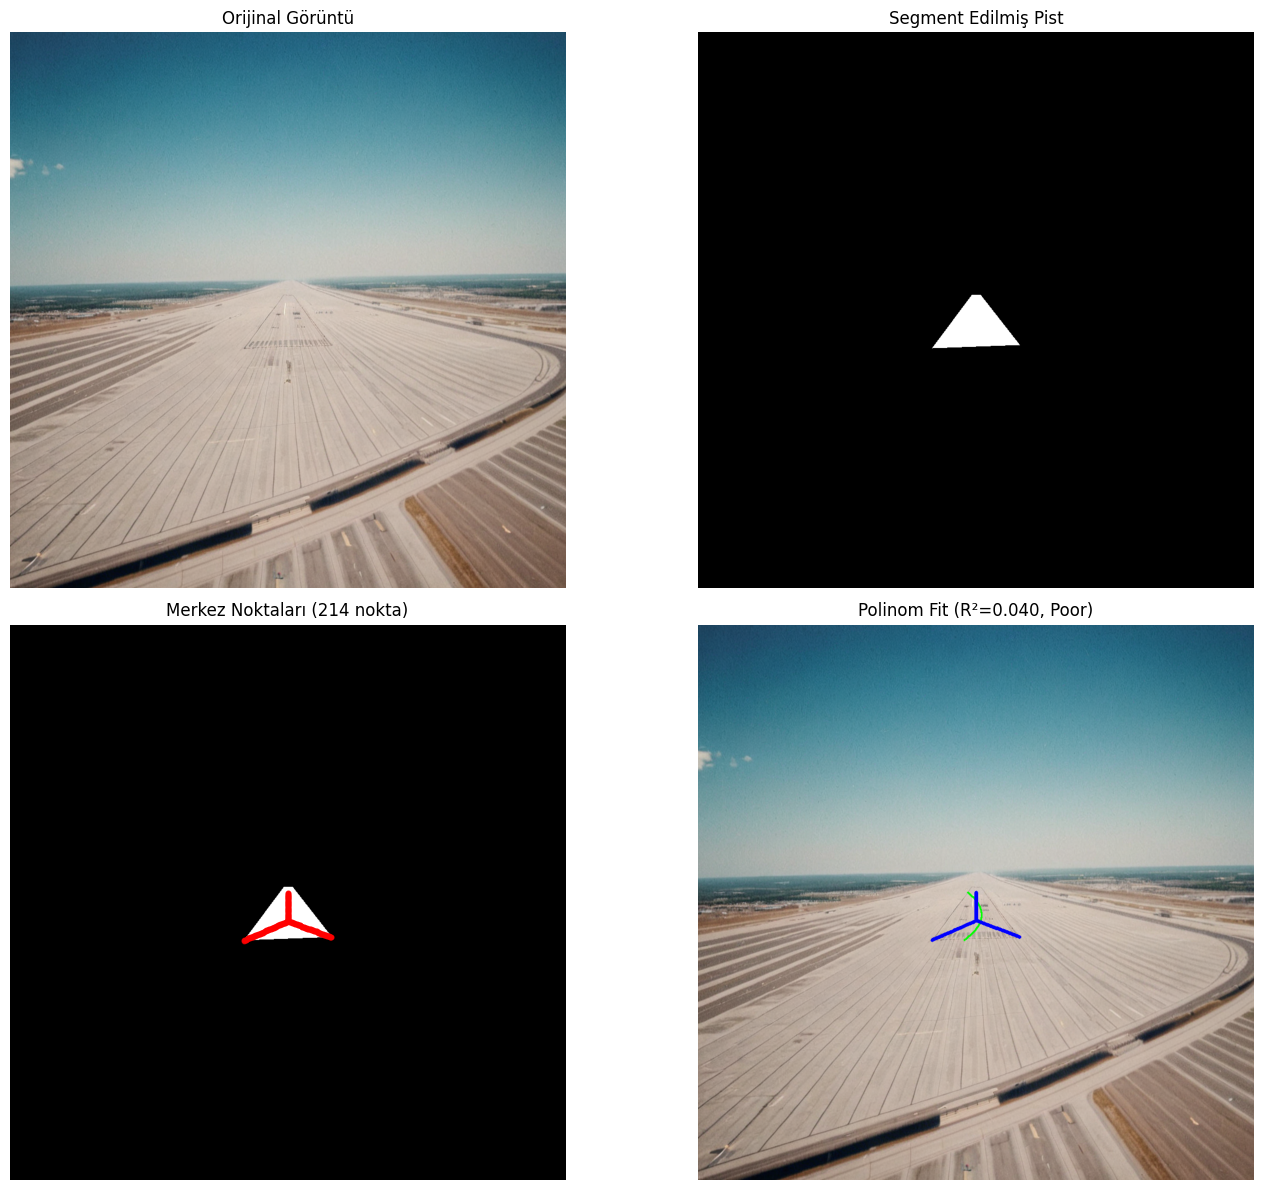


Kalite Analizi:
  fit_quality: Poor
  r2_score: 0.03957528180675185
  point_count: 214
  runway_length_pixels: 88
  runway_width_variation: 161
Sonuç kaydedildi: centerline_skeleton.png

=== POLİNOM DERECELERİ KARŞILAŞTIRMASI ===
Merkez hattı bulma yöntemi: distance_transform
Bulunan nokta sayısı: 99
Polinom fit başarılı - R² skoru: 0.6885
Polinom katsayıları: [ 0.         -0.73175015]
Derece 1: R² = 0.6885 (Poor)
Merkez hattı bulma yöntemi: distance_transform
Bulunan nokta sayısı: 99
Polinom fit başarılı - R² skoru: 0.9837
Polinom katsayıları: [ 0.00000000e+00  1.92532471e+01 -1.87476522e-02]
Derece 2: R² = 0.9837 (Excellent)
Merkez hattı bulma yöntemi: distance_transform
Bulunan nokta sayısı: 99
Polinom fit başarılı - R² skoru: 0.9868
Polinom katsayıları: [ 0.00000000e+00 -4.58783228e+01  1.03661519e-01 -7.65535781e-05]
Derece 3: R² = 0.9868 (Excellent)


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

def find_runway_centerline(mask, method='skeleton'):
    """
    Segment edilmiş pist maskesinden merkez hattını bulur

    Args:
        mask: Binary mask (0-255)
        method: 'skeleton', 'contour', 'distance_transform'
    """
    # Binary mask'e çevir
    binary_mask = (mask > 127).astype(np.uint8)

    if method == 'skeleton':
        return find_centerline_skeleton(binary_mask)
    elif method == 'contour':
        return find_centerline_contour(binary_mask)
    elif method == 'distance_transform':
        return find_centerline_distance_transform(binary_mask)
    else:
        raise ValueError("Method must be 'skeleton', 'contour', or 'distance_transform'")

def find_centerline_skeleton(binary_mask):
    """
    Skeletonization ile merkez hattı bulma
    """
    try:
        from skimage.morphology import skeletonize
        skeleton = skeletonize(binary_mask > 0).astype(np.uint8) * 255
    except ImportError:
        # Manuel skeleton (distance transform tabanlı)
        dist_transform = cv2.distanceTransform(binary_mask, cv2.DIST_L2, 5)
        skeleton = (dist_transform > np.max(dist_transform) * 0.7).astype(np.uint8) * 255

    # Skeleton noktalarını çıkar
    y_coords, x_coords = np.where(skeleton > 0)

    if len(x_coords) == 0:
        return np.array([])

    # Y koordinatına göre sırala
    sorted_indices = np.argsort(y_coords)
    points = np.column_stack((x_coords[sorted_indices], y_coords[sorted_indices]))

    return points

def find_centerline_contour(binary_mask):
    """
    Kontur tabanlı merkez hattı bulma
    """
    # Konturları bul
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if len(contours) == 0:
        return np.array([])

    # En büyük konturu seç
    largest_contour = max(contours, key=cv2.contourArea)

    # Konturun merkez hattını bul
    points = []
    contour_points = largest_contour.reshape(-1, 2)

    # Y koordinatına göre grupla ve her y seviyesinde x'in ortalamasını al
    y_min, y_max = contour_points[:, 1].min(), contour_points[:, 1].max()

    for y in range(y_min, y_max, 5):  # Her 5 pikselde bir sample al
        y_mask = np.abs(contour_points[:, 1] - y) <= 2
        if np.any(y_mask):
            x_coords = contour_points[y_mask, 0]
            x_center = (x_coords.min() + x_coords.max()) / 2
            points.append([x_center, y])

    return np.array(points) if points else np.array([])

def find_centerline_distance_transform(binary_mask):
    """
    Distance transform ile merkez hattı bulma
    """
    # Distance transform
    dist_transform = cv2.distanceTransform(binary_mask, cv2.DIST_L2, 5)

    # Her satırda maksimum mesafedeki noktayı bul
    points = []
    height, width = binary_mask.shape

    for y in range(height):
        row = dist_transform[y, :]
        if np.max(row) > 0:
            x_center = np.argmax(row)
            points.append([x_center, y])

    return np.array(points) if points else np.array([])

def fit_polynomial_to_centerline(points, degree=2, sample_points=100):
    """
    Merkez hat noktalarına polinom fit yapar

    Args:
        points: [[x1, y1], [x2, y2], ...] format
        degree: Polinom derecesi (1=linear, 2=quadratic, 3=cubic)
        sample_points: Çizim için kaç nokta kullanılacak
    """
    if len(points) < degree + 1:
        raise ValueError(f"Polinom derecesi {degree} için en az {degree + 1} nokta gerekli. Mevcut: {len(points)}")

    x_coords = points[:, 0]
    y_coords = points[:, 1]

    # Y'yi bağımsız değişken, X'i bağımlı değişken olarak kullan (dikey pist için)
    poly_pipeline = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    poly_pipeline.fit(y_coords.reshape(-1, 1), x_coords)

    # Fit kalitesini ölç
    x_pred = poly_pipeline.predict(y_coords.reshape(-1, 1))
    r2 = r2_score(x_coords, x_pred)

    # Çizim için smooth curve oluştur
    y_range = np.linspace(y_coords.min(), y_coords.max(), sample_points)
    x_fitted = poly_pipeline.predict(y_range.reshape(-1, 1))

    # Polinom katsayılarını çıkar
    poly_features = poly_pipeline.named_steps['polynomialfeatures']
    linear_reg = poly_pipeline.named_steps['linearregression']
    coefficients = linear_reg.coef_
    intercept = linear_reg.intercept_

    return {
        'model': poly_pipeline,
        'coefficients': coefficients,
        'intercept': intercept,
        'r2_score': r2,
        'curve_x': x_fitted,
        'curve_y': y_range,
        'original_points': points
    }

def draw_centerline_on_image(image, polynomial_result, line_color=(0, 255, 0), point_color=(255, 0, 0), thickness=2):
    """
    Görüntü üzerine merkez hattını çizer

    Args:
        image: BGR formatında görüntü
        polynomial_result: fit_polynomial_to_centerline() çıktısı
        line_color: Çizgi rengi (B, G, R)
        point_color: Nokta rengi (B, G, R)
        thickness: Çizgi kalınlığı
    """
    result_image = image.copy()

    # Polinom eğrisini çiz
    curve_points = np.column_stack((polynomial_result['curve_x'], polynomial_result['curve_y']))
    curve_points = curve_points.astype(np.int32)

    # Çizgi çiz
    for i in range(len(curve_points) - 1):
        pt1 = tuple(curve_points[i])
        pt2 = tuple(curve_points[i + 1])
        cv2.line(result_image, pt1, pt2, line_color, thickness)

    # Orijinal noktaları çiz
    for point in polynomial_result['original_points']:
        center = (int(point[0]), int(point[1]))
        cv2.circle(result_image, center, 3, point_color, -1)

    return result_image

def analyze_centerline_quality(polynomial_result):
    """
    Merkez hattı kalitesini analiz eder
    """
    r2 = polynomial_result['r2_score']
    points = polynomial_result['original_points']

    analysis = {
        'fit_quality': 'Excellent' if r2 > 0.95 else 'Good' if r2 > 0.9 else 'Fair' if r2 > 0.8 else 'Poor',
        'r2_score': r2,
        'point_count': len(points),
        'runway_length_pixels': abs(points[:, 1].max() - points[:, 1].min()),
        'runway_width_variation': abs(points[:, 0].max() - points[:, 0].min())
    }

    return analysis

def visualize_centerline_process(original_image, mask, centerline_points, polynomial_result):
    """
    Merkez hattı bulma sürecini görselleştirir
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Orijinal görüntü
    axes[0, 0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title('Orijinal Görüntü')
    axes[0, 0].axis('off')

    # Segment edilmiş mask
    axes[0, 1].imshow(mask, cmap='gray')
    axes[0, 1].set_title('Segment Edilmiş Pist')
    axes[0, 1].axis('off')

    # Bulunan merkez noktaları
    axes[1, 0].imshow(mask, cmap='gray')
    if len(centerline_points) > 0:
        axes[1, 0].scatter(centerline_points[:, 0], centerline_points[:, 1],
                          c='red', s=10, alpha=0.7)
    axes[1, 0].set_title(f'Merkez Noktaları ({len(centerline_points)} nokta)')
    axes[1, 0].axis('off')

    # Polinom fit sonucu
    result_image = draw_centerline_on_image(original_image, polynomial_result)
    axes[1, 1].imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))

    # Fit kalitesi bilgisi
    analysis = analyze_centerline_quality(polynomial_result)
    title = f"Polinom Fit (R²={analysis['r2_score']:.3f}, {analysis['fit_quality']})"
    axes[1, 1].set_title(title)
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

    return analysis

# Ana işlev
def process_runway_centerline(image_path, mask_path, method='skeleton', degree=2, visualization=True):
    """
    Pist merkez hattını bulma ve çizme ana fonksiyonu

    Args:
        image_path: Orijinal görüntü yolu
        mask_path: Segment edilmiş mask yolu
        method: Merkez hattı bulma yöntemi
        degree: Polinom derecesi
        visualization: Görselleştirme yapılsın mı
    """
    # Görüntüleri yükle
    original_image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if original_image is None or mask is None:
        raise ValueError("Görüntü veya mask yüklenemedi")

    # Merkez hattını bul
    print(f"Merkez hattı bulma yöntemi: {method}")
    centerline_points = find_runway_centerline(mask, method=method)

    if len(centerline_points) == 0:
        raise ValueError("Merkez hattı noktaları bulunamadı")

    print(f"Bulunan nokta sayısı: {len(centerline_points)}")

    # Polinom fit yap
    polynomial_result = fit_polynomial_to_centerline(centerline_points, degree=degree)

    print(f"Polinom fit başarılı - R² skoru: {polynomial_result['r2_score']:.4f}")
    print(f"Polinom katsayıları: {polynomial_result['coefficients']}")

    # Görselleştirme
    if visualization:
        analysis = visualize_centerline_process(original_image, mask, centerline_points, polynomial_result)
        print("\nKalite Analizi:")
        for key, value in analysis.items():
            print(f"  {key}: {value}")

    # Sonuç görüntüsünü oluştur
    result_image = draw_centerline_on_image(original_image, polynomial_result)

    return {
        'result_image': result_image,
        'polynomial_result': polynomial_result,
        'centerline_points': centerline_points,
        'analysis': analyze_centerline_quality(polynomial_result)
    }

# Örnek kullanım
if __name__ == "__main__":
    try:
        # Dosya yolları
        image_path = "/content/drive/MyDrive/runway_detection_and_tracking/split_dataset/PNG/-KOP9Kub9t8_085__day_2.png"  # Orijinal görüntü
        mask_path = "/content/drive/MyDrive/runway_detection_and_tracking/split_dataset/MASK_PNG/-KOP9Kub9t8_085__day_2.mask.png"       # U-Net çıktısı

        # Farklı yöntemleri dene
        methods = ['skeleton', 'distance_transform', 'contour']

        for method in methods:
            try:
                print(f"\n=== {method.upper()} YÖNTEMİ ===")
                result = process_runway_centerline(
                    image_path,
                    mask_path,
                    method=method,
                    degree=2,
                    visualization=True
                )

                # Sonucu kaydet
                output_filename = f"centerline_{method}.png"
                cv2.imwrite(output_filename, result['result_image'])
                print(f"Sonuç kaydedildi: {output_filename}")

                break  # İlk başarılı yöntemle devam et

            except Exception as e:
                print(f"{method} yöntemi başarısız: {e}")
                continue

        # Polinom dereceleri karşılaştırması
        print("\n=== POLİNOM DERECELERİ KARŞILAŞTIRMASI ===")
        for degree in [1, 2, 3]:
            try:
                result = process_runway_centerline(
                    image_path,
                    mask_path,
                    method='distance_transform',
                    degree=degree,
                    visualization=False
                )

                analysis = result['analysis']
                print(f"Derece {degree}: R² = {analysis['r2_score']:.4f} ({analysis['fit_quality']})")

            except Exception as e:
                print(f"Derece {degree} başarısız: {e}")

    except Exception as e:
        print(f"Ana hata: {e}")
        print("\nKontrol edilecekler:")
        print("1. Dosya yolları doğru mu?")
        print("2. Gerekli kütüphaneler kurulu mu? (pip install scikit-learn matplotlib)")
        print("3. Mask dosyası geçerli mi?")

=== DISTANCE TRANSFORM YÖNTEMİ - 2. DERECE POLİNOM ===
Merkez hattı bulma yöntemi: distance_transform
Bulunan nokta sayısı: 99
2. derece polinom fit başarılı - R² skoru: 0.9837
Polinom katsayıları: [ 0.00000000e+00  1.92532471e+01 -1.87476522e-02]


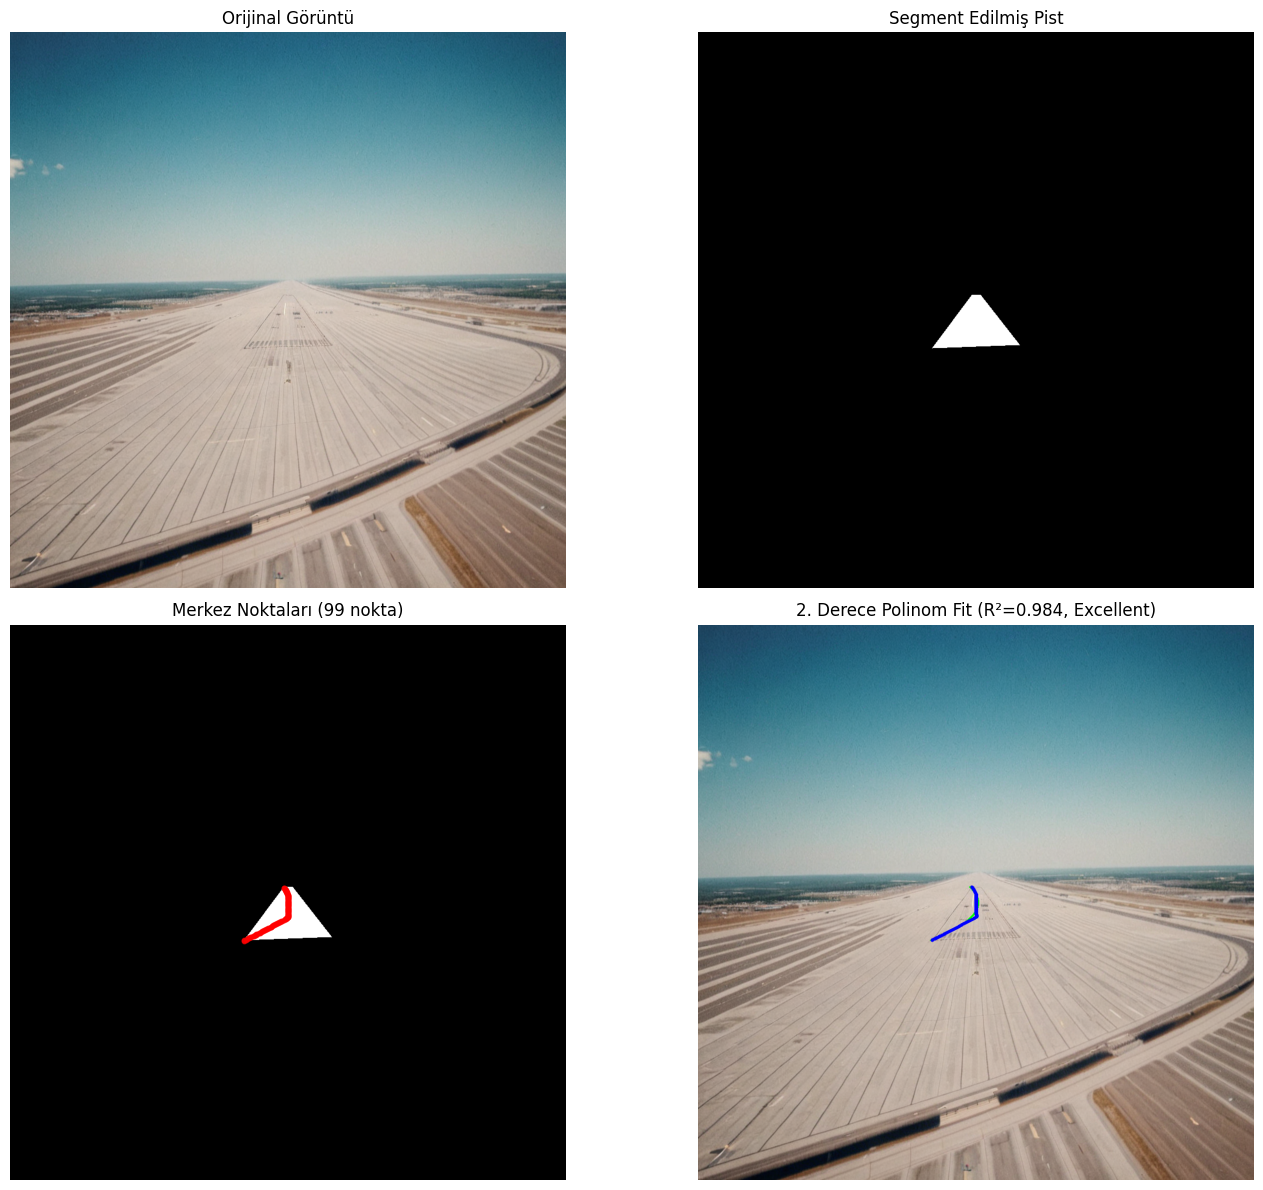


Kalite Analizi:
  fit_quality: Excellent
  r2_score: 0.9836624829365728
  point_count: 99
  runway_length_pixels: 98
  runway_width_variation: 82
Sonuç kaydedildi: centerline_distance_transform_degree2.png


In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

def find_centerline_distance_transform(binary_mask):
    """
    Distance transform ile merkez hattı bulma
    """
    # Distance transform
    dist_transform = cv2.distanceTransform(binary_mask, cv2.DIST_L2, 5)

    # Her satırda maksimum mesafedeki noktayı bul
    points = []
    height, width = binary_mask.shape

    for y in range(height):
        row = dist_transform[y, :]
        if np.max(row) > 0:
            x_center = np.argmax(row)
            points.append([x_center, y])

    return np.array(points) if points else np.array([])

def find_runway_centerline(mask):
    """
    Segment edilmiş pist maskesinden merkez hattını bulur (distance transform yöntemi)

    Args:
        mask: Binary mask (0-255)
    """
    # Binary mask'e çevir
    binary_mask = (mask > 127).astype(np.uint8)

    return find_centerline_distance_transform(binary_mask)

def fit_polynomial_to_centerline(points, sample_points=100):
    """
    Merkez hat noktalarına 2. derece polinom fit yapar

    Args:
        points: [[x1, y1], [x2, y2], ...] format
        sample_points: Çizim için kaç nokta kullanılacak
    """
    if len(points) < 3:
        raise ValueError(f"2. derece polinom için en az 3 nokta gerekli. Mevcut: {len(points)}")

    x_coords = points[:, 0]
    y_coords = points[:, 1]

    # Y'yi bağımsız değişken, X'i bağımlı değişken olarak kullan (dikey pist için)
    poly_pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())
    poly_pipeline.fit(y_coords.reshape(-1, 1), x_coords)

    # Fit kalitesini ölç
    x_pred = poly_pipeline.predict(y_coords.reshape(-1, 1))
    r2 = r2_score(x_coords, x_pred)

    # Çizim için smooth curve oluştur
    y_range = np.linspace(y_coords.min(), y_coords.max(), sample_points)
    x_fitted = poly_pipeline.predict(y_range.reshape(-1, 1))

    # Polinom katsayılarını çıkar
    poly_features = poly_pipeline.named_steps['polynomialfeatures']
    linear_reg = poly_pipeline.named_steps['linearregression']
    coefficients = linear_reg.coef_
    intercept = linear_reg.intercept_

    return {
        'model': poly_pipeline,
        'coefficients': coefficients,
        'intercept': intercept,
        'r2_score': r2,
        'curve_x': x_fitted,
        'curve_y': y_range,
        'original_points': points
    }

def draw_centerline_on_image(image, polynomial_result, line_color=(0, 255, 0), point_color=(255, 0, 0), thickness=2):
    """
    Görüntü üzerine merkez hattını çizer

    Args:
        image: BGR formatında görüntü
        polynomial_result: fit_polynomial_to_centerline() çıktısı
        line_color: Çizgi rengi (B, G, R)
        point_color: Nokta rengi (B, G, R)
        thickness: Çizgi kalınlığı
    """
    result_image = image.copy()

    # Polinom eğrisini çiz
    curve_points = np.column_stack((polynomial_result['curve_x'], polynomial_result['curve_y']))
    curve_points = curve_points.astype(np.int32)

    # Çizgi çiz
    for i in range(len(curve_points) - 1):
        pt1 = tuple(curve_points[i])
        pt2 = tuple(curve_points[i + 1])
        cv2.line(result_image, pt1, pt2, line_color, thickness)

    # Orijinal noktaları çiz
    for point in polynomial_result['original_points']:
        center = (int(point[0]), int(point[1]))
        cv2.circle(result_image, center, 3, point_color, -1)

    return result_image

def analyze_centerline_quality(polynomial_result):
    """
    Merkez hattı kalitesini analiz eder
    """
    r2 = polynomial_result['r2_score']
    points = polynomial_result['original_points']

    analysis = {
        'fit_quality': 'Excellent' if r2 > 0.95 else 'Good' if r2 > 0.9 else 'Fair' if r2 > 0.8 else 'Poor',
        'r2_score': r2,
        'point_count': len(points),
        'runway_length_pixels': abs(points[:, 1].max() - points[:, 1].min()),
        'runway_width_variation': abs(points[:, 0].max() - points[:, 0].min())
    }

    return analysis

def visualize_centerline_process(original_image, mask, centerline_points, polynomial_result):
    """
    Merkez hattı bulma sürecini görselleştirir
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Orijinal görüntü
    axes[0, 0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title('Orijinal Görüntü')
    axes[0, 0].axis('off')

    # Segment edilmiş mask
    axes[0, 1].imshow(mask, cmap='gray')
    axes[0, 1].set_title('Segment Edilmiş Pist')
    axes[0, 1].axis('off')

    # Bulunan merkez noktaları
    axes[1, 0].imshow(mask, cmap='gray')
    if len(centerline_points) > 0:
        axes[1, 0].scatter(centerline_points[:, 0], centerline_points[:, 1],
                          c='red', s=10, alpha=0.7)
    axes[1, 0].set_title(f'Merkez Noktaları ({len(centerline_points)} nokta)')
    axes[1, 0].axis('off')

    # Polinom fit sonucu
    result_image = draw_centerline_on_image(original_image, polynomial_result)
    axes[1, 1].imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))

    # Fit kalitesi bilgisi
    analysis = analyze_centerline_quality(polynomial_result)
    title = f"2. Derece Polinom Fit (R²={analysis['r2_score']:.3f}, {analysis['fit_quality']})"
    axes[1, 1].set_title(title)
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

    return analysis

def process_runway_centerline(image_path, mask_path, visualization=True):
    """
    Pist merkez hattını bulma ve çizme ana fonksiyonu
    Distance transform yöntemi ve 2. derece polinom kullanır

    Args:
        image_path: Orijinal görüntü yolu
        mask_path: Segment edilmiş mask yolu
        visualization: Görselleştirme yapılsın mı
    """
    # Görüntüleri yükle
    original_image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if original_image is None or mask is None:
        raise ValueError("Görüntü veya mask yüklenemedi")

    # Merkez hattını bul (distance transform yöntemi)
    print("Merkez hattı bulma yöntemi: distance_transform")
    centerline_points = find_runway_centerline(mask)

    if len(centerline_points) == 0:
        raise ValueError("Merkez hattı noktaları bulunamadı")

    print(f"Bulunan nokta sayısı: {len(centerline_points)}")

    # 2. derece polinom fit yap
    polynomial_result = fit_polynomial_to_centerline(centerline_points)

    print(f"2. derece polinom fit başarılı - R² skoru: {polynomial_result['r2_score']:.4f}")
    print(f"Polinom katsayıları: {polynomial_result['coefficients']}")

    # Görselleştirme
    if visualization:
        analysis = visualize_centerline_process(original_image, mask, centerline_points, polynomial_result)
        print("\nKalite Analizi:")
        for key, value in analysis.items():
            print(f"  {key}: {value}")

    # Sonuç görüntüsünü oluştur
    result_image = draw_centerline_on_image(original_image, polynomial_result)

    return {
        'result_image': result_image,
        'polynomial_result': polynomial_result,
        'centerline_points': centerline_points,
        'analysis': analyze_centerline_quality(polynomial_result)
    }

# Örnek kullanım
if __name__ == "__main__":
    try:
        # Dosya yolları
        image_path = "/content/drive/MyDrive/runway_detection_and_tracking/split_dataset/PNG/-KOP9Kub9t8_085__day_2.png"  # Orijinal görüntü
        mask_path = "/content/drive/MyDrive/runway_detection_and_tracking/split_dataset/MASK_PNG/-KOP9Kub9t8_085__day_2.mask.png"       # U-Net çıktısı

        print("=== DISTANCE TRANSFORM YÖNTEMİ - 2. DERECE POLİNOM ===")
        result = process_runway_centerline(
            image_path,
            mask_path,
            visualization=True
        )

        # Sonucu kaydet
        output_filename = "centerline_distance_transform_degree2.png"
        cv2.imwrite(output_filename, result['result_image'])
        print(f"Sonuç kaydedildi: {output_filename}")

    except Exception as e:
        print(f"Hata: {e}")
        print("\nKontrol edilecekler:")
        print("1. Dosya yolları doğru mu?")
        print("2. Gerekli kütüphaneler kurulu mu? (pip install scikit-learn matplotlib)")
        print("3. Mask dosyası geçerli mi?")

🚀 Geliştirilmiş Pist Merkez Hattı Analizi Başlatılıyor...
🔍 Merkez hattı bulunuyor...
✅ 50 merkez noktası bulundu
📐 2. derece polinom fitting yapılıyor...
✅ Polinom fit tamamlandı - R² skoru: 0.9706
🎯 Mükemmel fit kalitesi!
📊 Görselleştirme hazırlanıyor...


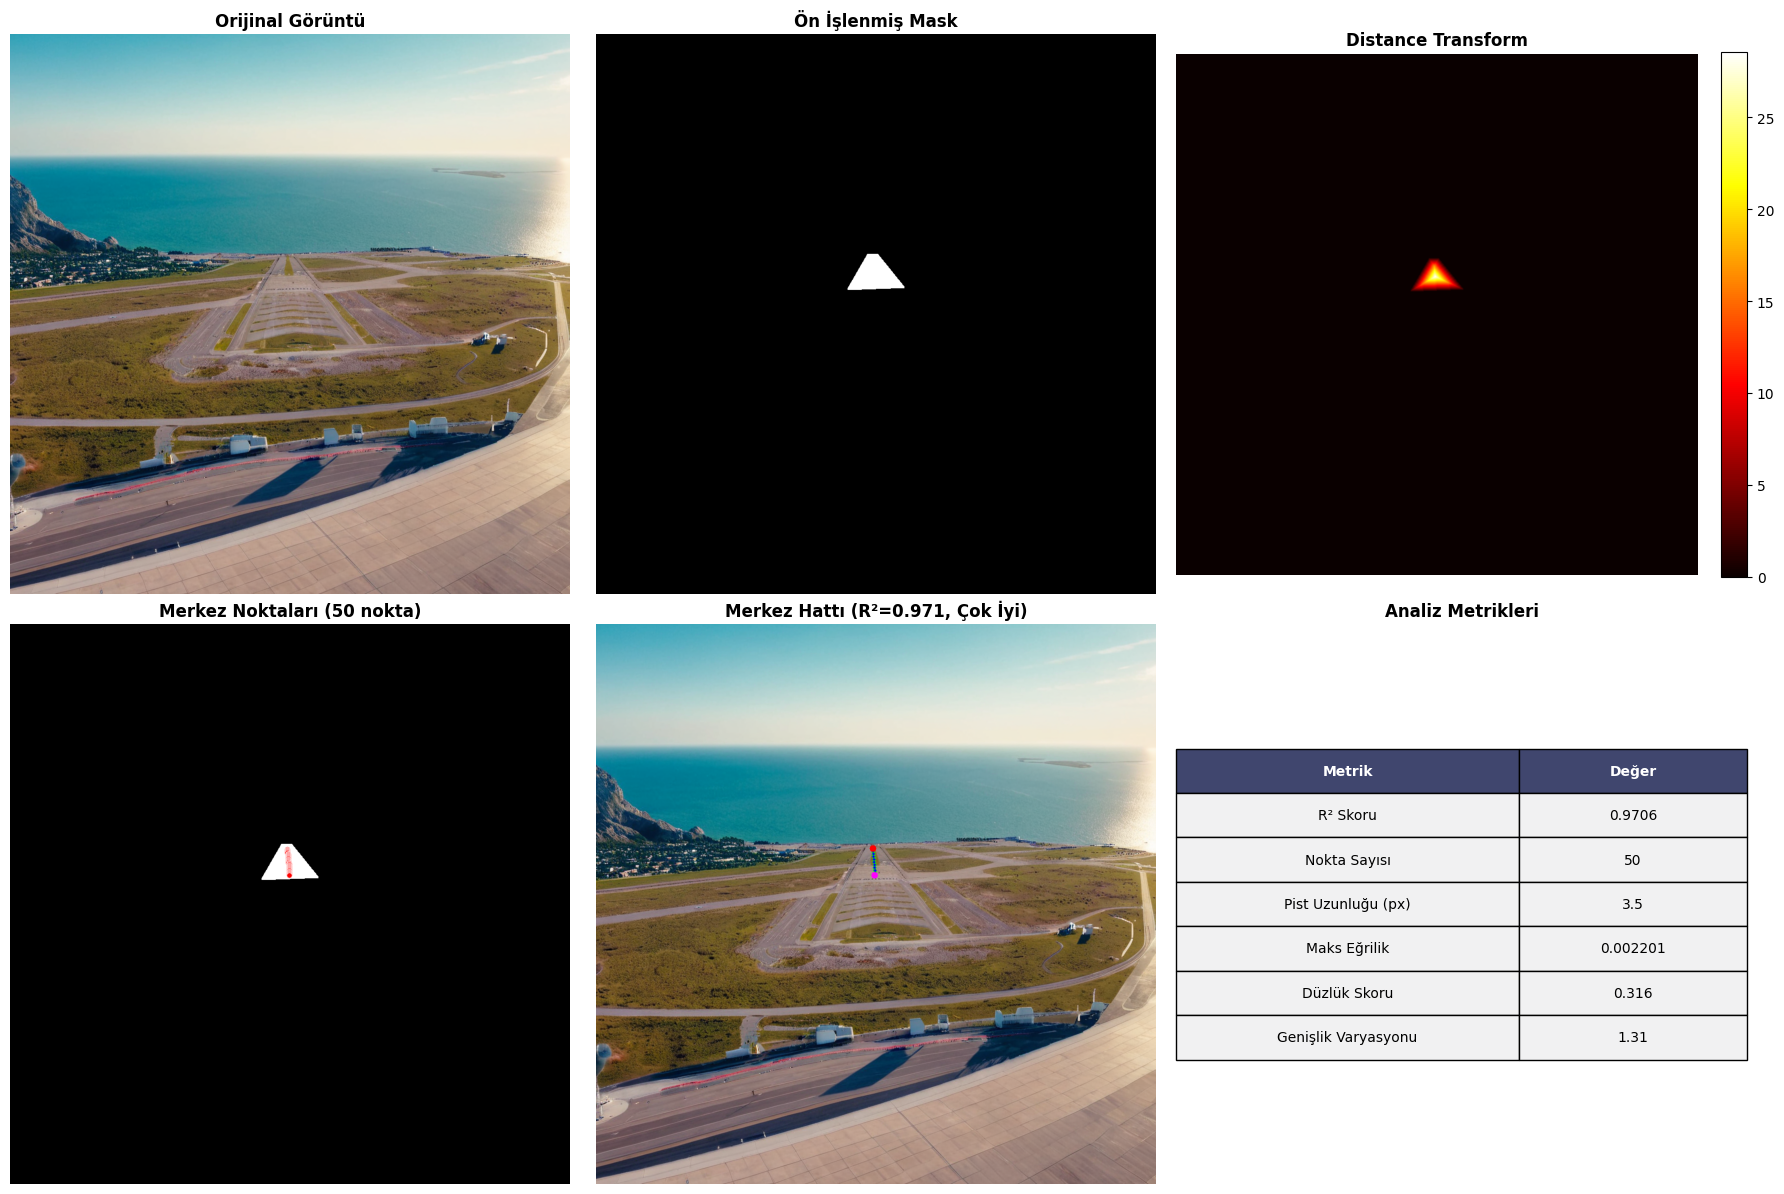


📈 Detaylı Analiz:
  • Pist Uzunluğu: 3.5 piksel
  • Düzlük Skoru: 0.316 (1.0 = mükemmel düz)
  • Genişlik Varyasyonu: 1.31 piksel

💾 Sonuç kaydedildi: enhanced_centerline_result.png

🎉 İşlem başarıyla tamamlandı!


In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from scipy.ndimage import gaussian_filter1d

def preprocess_mask(mask):
    """
    Mask'i ön işleme tabi tutar
    """
    # Binary mask'e çevir
    binary_mask = (mask > 127).astype(np.uint8)

    # Morfolojik işlemler ile gürültüyü azalt
    kernel = np.ones((3, 3), np.uint8)
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

    # Büyük boşlukları doldur
    kernel_large = np.ones((5, 5), np.uint8)
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel_large)

    return binary_mask

def find_centerline_improved_distance_transform(binary_mask):
    """
    Geliştirilmiş distance transform ile merkez hattı bulma
    """
    # Distance transform
    dist_transform = cv2.distanceTransform(binary_mask, cv2.DIST_L2, 5)

    # Gaussian blur ile smooth yap
    dist_transform = cv2.GaussianBlur(dist_transform, (5, 5), 1)

    # Her satırda maksimum mesafedeki noktaları bul
    points = []
    height, width = binary_mask.shape

    # Minimum genişlik threshold'u
    min_width_threshold = np.max(dist_transform) * 0.3

    for y in range(height):
        row_dist = dist_transform[y, :]
        row_mask = binary_mask[y, :]

        # Bu satırda pist var mı kontrol et
        if np.max(row_dist) > min_width_threshold and np.sum(row_mask) > 10:
            # Ağırlıklı merkez hesapla
            indices = np.arange(width)
            weights = row_dist * row_mask

            if np.sum(weights) > 0:
                x_center = np.average(indices, weights=weights)
                points.append([x_center, y])

    if not points:
        return np.array([])

    points = np.array(points)

    # Outlier'ları temizle
    points = remove_outliers(points)

    # Y koordinatına göre sırala
    sorted_indices = np.argsort(points[:, 1])
    points = points[sorted_indices]

    # X koordinatlarını smoothing yap
    if len(points) > 5:
        points[:, 0] = gaussian_filter1d(points[:, 0], sigma=2)

    return points

def remove_outliers(points, threshold=2.5):
    """
    Outlier noktaları temizle
    """
    if len(points) < 5:
        return points

    x_coords = points[:, 0]

    # Z-score ile outlier tespiti
    mean_x = np.mean(x_coords)
    std_x = np.std(x_coords)

    if std_x == 0:
        return points

    z_scores = np.abs((x_coords - mean_x) / std_x)
    mask = z_scores < threshold

    return points[mask]

def adaptive_polynomial_fit(points, target_r2=0.95):
    """
    Adaptif polinom fitting - 2. derece polinom ile başlayıp optimize eder
    """
    if len(points) < 3:
        raise ValueError("En az 3 nokta gerekli")

    x_coords = points[:, 0]
    y_coords = points[:, 1]

    # 2. derece polinom fit yap
    poly_pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())
    poly_pipeline.fit(y_coords.reshape(-1, 1), x_coords)

    # Fit kalitesini ölç
    x_pred = poly_pipeline.predict(y_coords.reshape(-1, 1))
    r2 = r2_score(x_coords, x_pred)

    # Eğer fit kalitesi düşükse, outlier'ları tekrar temizle
    if r2 < target_r2 and len(points) > 10:
        residuals = np.abs(x_coords - x_pred)
        threshold = np.percentile(residuals, 85)  # En kötü %15'i çıkar
        good_points_mask = residuals <= threshold

        if np.sum(good_points_mask) >= 3:
            filtered_points = points[good_points_mask]

            # Yeniden fit yap
            x_coords = filtered_points[:, 0]
            y_coords = filtered_points[:, 1]

            poly_pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())
            poly_pipeline.fit(y_coords.reshape(-1, 1), x_coords)

            x_pred = poly_pipeline.predict(y_coords.reshape(-1, 1))
            r2 = r2_score(x_coords, x_pred)

            points = filtered_points

    # Çizim için smooth curve oluştur
    y_range = np.linspace(y_coords.min(), y_coords.max(), 200)
    x_fitted = poly_pipeline.predict(y_range.reshape(-1, 1))

    # Polinom katsayılarını çıkar
    linear_reg = poly_pipeline.named_steps['linearregression']
    coefficients = linear_reg.coef_
    intercept = linear_reg.intercept_

    return {
        'model': poly_pipeline,
        'coefficients': coefficients,
        'intercept': intercept,
        'r2_score': r2,
        'curve_x': x_fitted,
        'curve_y': y_range,
        'original_points': points
    }

def find_runway_centerline(mask):
    """
    Segment edilmiş pist maskesinden merkez hattını bulur
    """
    # Mask'i ön işle
    binary_mask = preprocess_mask(mask)

    # Merkez hattı noktalarını bul
    centerline_points = find_centerline_improved_distance_transform(binary_mask)

    return centerline_points

def draw_enhanced_centerline(image, polynomial_result, line_color=(0, 255, 0), point_color=(255, 0, 0), thickness=3):
    """
    Geliştirilmiş merkez hattı çizimi
    """
    result_image = image.copy()

    # Polinom eğrisini çiz
    curve_points = np.column_stack((polynomial_result['curve_x'], polynomial_result['curve_y']))
    curve_points = curve_points.astype(np.int32)

    # Anti-aliased çizgi için polylines kullan
    cv2.polylines(result_image, [curve_points], False, line_color, thickness, cv2.LINE_AA)

    # Orijinal noktaları küçük daireler olarak çiz
    for point in polynomial_result['original_points'][::5]:  # Her 5 noktada bir göster
        center = (int(point[0]), int(point[1]))
        cv2.circle(result_image, center, 2, point_color, -1, cv2.LINE_AA)

    # Başlangıç ve bitiş noktalarını vurgula
    if len(polynomial_result['original_points']) > 0:
        start_point = polynomial_result['original_points'][0]
        end_point = polynomial_result['original_points'][-1]

        cv2.circle(result_image, (int(start_point[0]), int(start_point[1])), 6, (0, 0, 255), -1)
        cv2.circle(result_image, (int(end_point[0]), int(end_point[1])), 6, (255, 0, 255), -1)

    return result_image

def calculate_runway_metrics(polynomial_result):
    """
    Pist metriklerini hesaplar
    """
    points = polynomial_result['original_points']
    curve_x = polynomial_result['curve_x']
    curve_y = polynomial_result['curve_y']

    # Pist uzunluğu
    runway_length = np.sqrt(np.sum(np.diff(curve_x)**2 + np.diff(curve_y)**2))

    # Eğrilik analizi
    dx = np.gradient(curve_x)
    dy = np.gradient(curve_y)
    d2x = np.gradient(dx)
    d2y = np.gradient(dy)

    curvature = np.abs(dx * d2y - dy * d2x) / (dx**2 + dy**2)**1.5
    max_curvature = np.max(curvature[~np.isnan(curvature)])
    avg_curvature = np.mean(curvature[~np.isnan(curvature)])

    # Pist genişliği varyasyonu
    width_variation = np.std(points[:, 0])

    metrics = {
        'runway_length_pixels': runway_length,
        'max_curvature': max_curvature,
        'avg_curvature': avg_curvature,
        'width_variation': width_variation,
        'straightness_score': 1.0 / (1.0 + avg_curvature * 1000)  # 0-1 arası düzlük skoru
    }

    return metrics

def visualize_enhanced_process(original_image, mask, centerline_points, polynomial_result):
    """
    Geliştirilmiş görselleştirme
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Orijinal görüntü
    axes[0, 0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title('Orijinal Görüntü', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')

    # Ön işlenmiş mask
    processed_mask = preprocess_mask(mask)
    axes[0, 1].imshow(processed_mask, cmap='gray')
    axes[0, 1].set_title('Ön İşlenmiş Mask', fontsize=12, fontweight='bold')
    axes[0, 1].axis('off')

    # Distance transform
    dist_transform = cv2.distanceTransform(processed_mask, cv2.DIST_L2, 5)
    im = axes[0, 2].imshow(dist_transform, cmap='hot')
    axes[0, 2].set_title('Distance Transform', fontsize=12, fontweight='bold')
    axes[0, 2].axis('off')
    plt.colorbar(im, ax=axes[0, 2], fraction=0.046, pad=0.04)

    # Bulunan merkez noktaları
    axes[1, 0].imshow(processed_mask, cmap='gray')
    if len(centerline_points) > 0:
        axes[1, 0].scatter(centerline_points[:, 0], centerline_points[:, 1],
                          c='red', s=15, alpha=0.8, edgecolors='white', linewidth=0.5)
    axes[1, 0].set_title(f'Merkez Noktaları ({len(centerline_points)} nokta)',
                        fontsize=12, fontweight='bold')
    axes[1, 0].axis('off')

    # Polinom fit sonucu
    result_image = draw_enhanced_centerline(original_image, polynomial_result)
    axes[1, 1].imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))

    r2 = polynomial_result['r2_score']
    fit_quality = 'Mükemmel' if r2 > 0.98 else 'Çok İyi' if r2 > 0.95 else 'İyi' if r2 > 0.9 else 'Orta' if r2 > 0.8 else 'Zayıf'
    axes[1, 1].set_title(f'Merkez Hattı (R²={r2:.3f}, {fit_quality})',
                        fontsize=12, fontweight='bold')
    axes[1, 1].axis('off')

    # Metrikler tablosu
    metrics = calculate_runway_metrics(polynomial_result)
    axes[1, 2].axis('off')

    # Tablo oluştur
    table_data = [
        ['Metrik', 'Değer'],
        ['R² Skoru', f'{r2:.4f}'],
        ['Nokta Sayısı', f'{len(centerline_points)}'],
        ['Pist Uzunluğu (px)', f'{metrics["runway_length_pixels"]:.1f}'],
        ['Maks Eğrilik', f'{metrics["max_curvature"]:.6f}'],
        ['Düzlük Skoru', f'{metrics["straightness_score"]:.3f}'],
        ['Genişlik Varyasyonu', f'{metrics["width_variation"]:.2f}']
    ]

    table = axes[1, 2].table(cellText=table_data[1:], colLabels=table_data[0],
                            cellLoc='center', loc='center',
                            colWidths=[0.6, 0.4])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)

    # Başlık hücrelerini vurgula
    for (i, j), cell in table.get_celld().items():
        if i == 0:
            cell.set_text_props(weight='bold')
            cell.set_facecolor('#40466e')
            cell.set_text_props(color='white')
        else:
            cell.set_facecolor('#f1f1f2')

    axes[1, 2].set_title('Analiz Metrikleri', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

    return metrics

def process_runway_centerline(image_path, mask_path, visualization=True):
    """
    Geliştirilmiş pist merkez hattı işleme fonksiyonu
    """
    # Görüntüleri yükle
    original_image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if original_image is None or mask is None:
        raise ValueError("Görüntü veya mask yüklenemedi")

    print("🔍 Merkez hattı bulunuyor...")
    centerline_points = find_runway_centerline(mask)

    if len(centerline_points) == 0:
        raise ValueError("Merkez hattı noktaları bulunamadı")

    print(f"✅ {len(centerline_points)} merkez noktası bulundu")

    print("📐 2. derece polinom fitting yapılıyor...")
    polynomial_result = adaptive_polynomial_fit(centerline_points)

    r2 = polynomial_result['r2_score']
    print(f"✅ Polinom fit tamamlandı - R² skoru: {r2:.4f}")

    if r2 > 0.95:
        print("🎯 Mükemmel fit kalitesi!")
    elif r2 > 0.9:
        print("👍 İyi fit kalitesi")
    else:
        print("⚠️  Orta fit kalitesi - mask kalitesini kontrol edin")

    # Görselleştirme
    if visualization:
        print("📊 Görselleştirme hazırlanıyor...")
        metrics = visualize_enhanced_process(original_image, mask, centerline_points, polynomial_result)

        print("\n📈 Detaylı Analiz:")
        print(f"  • Pist Uzunluğu: {metrics['runway_length_pixels']:.1f} piksel")
        print(f"  • Düzlük Skoru: {metrics['straightness_score']:.3f} (1.0 = mükemmel düz)")
        print(f"  • Genişlik Varyasyonu: {metrics['width_variation']:.2f} piksel")

    # Sonuç görüntüsünü oluştur
    result_image = draw_enhanced_centerline(original_image, polynomial_result)

    return {
        'result_image': result_image,
        'polynomial_result': polynomial_result,
        'centerline_points': centerline_points,
        'metrics': calculate_runway_metrics(polynomial_result) if visualization else None
    }

# Ana çalıştırma
if __name__ == "__main__":
    try:
        # Dosya yolları
        image_path = "/content/drive/MyDrive/runway_detection_and_tracking/split_dataset/PNG/17MUtbOfdNQ_101__day_3.png"
        mask_path = "/content/drive/MyDrive/runway_detection_and_tracking/split_dataset/MASK_PNG/17MUtbOfdNQ_101__day_3.mask.png"

        print("🚀 Geliştirilmiş Pist Merkez Hattı Analizi Başlatılıyor...")
        print("="*60)

        result = process_runway_centerline(
            image_path,
            mask_path,
            visualization=True
        )

        # Sonucu kaydet
        output_filename = "enhanced_centerline_result.png"
        cv2.imwrite(output_filename, result['result_image'])
        print(f"\n💾 Sonuç kaydedildi: {output_filename}")

        print("\n🎉 İşlem başarıyla tamamlandı!")

    except Exception as e:
        print(f"❌ Hata: {e}")
        print("\n🔧 Kontrol Listesi:")
        print("  1. Dosya yolları doğru mu?")
        print("  2. Gerekli kütüphaneler kurulu mu?")
        print("     pip install scikit-learn matplotlib scipy")
        print("  3. Mask dosyası geçerli bir binary mask mi?")
        print("  4. Mask'te pist bölgesi beyaz (255) değerinde mi?")

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import math

class RunwayDeviationAnalyzer:
    def __init__(self):
        self.polynomial_model = None
        self.image_shape = None
        self.deviation_history = []

    def calculate_deviation(self, polynomial_result, image_shape):
        """
        Uçak-pist sapmasını hesaplar

        Args:
            polynomial_result: Polinom fit sonucu
            image_shape: (height, width, channels) veya (height, width)

        Returns:
            dict: Sapma analiz sonuçları
        """
        self.polynomial_model = polynomial_result['model']
        self.image_shape = image_shape

        height, width = image_shape[:2]

        # Uçak pozisyonu (görüntü merkezi)
        aircraft_x = width // 2
        aircraft_y = height // 2

        # Bu Y koordinatında pist merkez hattının X pozisyonu
        runway_center_x = self.polynomial_model.predict([[aircraft_y]])[0]

        # Yatay sapma (pozitif = sağa sapma, negatif = sola sapma)
        horizontal_deviation = aircraft_x - runway_center_x

        # Pist genişliği tahmin et (ortalama değer kullan)
        runway_width_estimate = self._estimate_runway_width(polynomial_result)

        # Sapma yüzdesi (pist genişliğine göre)
        if runway_width_estimate > 0:
            deviation_percentage = (abs(horizontal_deviation) / runway_width_estimate) * 100
        else:
            deviation_percentage = 0

        # Sapma seviyesi belirleme
        deviation_level = self._classify_deviation(abs(horizontal_deviation), runway_width_estimate)

        # En yakın nokta mesafesi (Euclidean distance)
        closest_point_distance = self._find_closest_point_distance(
            aircraft_x, aircraft_y, polynomial_result
        )

        # Pist açısı hesapla
        runway_angle = self._calculate_runway_angle(polynomial_result, aircraft_y)

        deviation_data = {
            'aircraft_position': (aircraft_x, aircraft_y),
            'runway_center_x': runway_center_x,
            'horizontal_deviation': horizontal_deviation,
            'deviation_pixels': abs(horizontal_deviation),
            'deviation_percentage': deviation_percentage,
            'deviation_level': deviation_level,
            'deviation_direction': 'RIGHT' if horizontal_deviation > 0 else 'LEFT' if horizontal_deviation < 0 else 'CENTER',
            'closest_point_distance': closest_point_distance,
            'runway_angle': runway_angle,
            'runway_width_estimate': runway_width_estimate,
            'is_aligned': abs(horizontal_deviation) < runway_width_estimate * 0.1  # %10 tolerance
        }

        # Geçmiş verilere ekle
        self.deviation_history.append(deviation_data)

        return deviation_data

    def _estimate_runway_width(self, polynomial_result):
        """
        Pist genişliğini tahmin et
        """
        points = polynomial_result['original_points']
        if len(points) == 0:
            return 100  # Default değer

        # Nokta dağılımından genişlik tahmin et
        width_variation = np.std(points[:, 0])
        estimated_width = max(width_variation * 4, 50)  # Minimum 50 pixel

        return estimated_width

    def _classify_deviation(self, deviation_pixels, runway_width):
        """
        Sapma seviyesini sınıflandır
        """
        if runway_width == 0:
            return "UNKNOWN"

        deviation_ratio = deviation_pixels / runway_width

        if deviation_ratio < 0.05:
            return "PERFECT"
        elif deviation_ratio < 0.15:
            return "EXCELLENT"
        elif deviation_ratio < 0.3:
            return "GOOD"
        elif deviation_ratio < 0.5:
            return "FAIR"
        else:
            return "POOR"

    def _find_closest_point_distance(self, aircraft_x, aircraft_y, polynomial_result):
        """
        Uçağın pist merkez hattına en yakın noktasının mesafesini hesapla
        """
        curve_x = polynomial_result['curve_x']
        curve_y = polynomial_result['curve_y']

        # Tüm noktalara olan mesafeleri hesapla
        distances = np.sqrt((curve_x - aircraft_x)**2 + (curve_y - aircraft_y)**2)

        return np.min(distances)

    def _calculate_runway_angle(self, polynomial_result, y_position):
        """
        Belirli bir Y pozisyonunda pist açısını hesapla
        """
        model = polynomial_result['model']

        # Küçük bir değişim ile türev hesapla
        y1 = y_position - 5
        y2 = y_position + 5

        x1 = model.predict([[y1]])[0]
        x2 = model.predict([[y2]])[0]

        # Açı hesapla (derece cinsinden)
        angle_rad = math.atan2(x2 - x1, y2 - y1)
        angle_deg = math.degrees(angle_rad)

        return angle_deg

    def draw_deviation_overlay(self, image, deviation_data, polynomial_result):
        """
        Sapma bilgilerini görüntü üzerine çizer
        """
        overlay_image = image.copy()
        height, width = image.shape[:2]

        aircraft_x, aircraft_y = deviation_data['aircraft_position']
        runway_center_x = deviation_data['runway_center_x']

        # Uçak pozisyonu (merkez nokta)
        cv2.circle(overlay_image, (int(aircraft_x), int(aircraft_y)), 8, (0, 0, 255), -1)
        cv2.circle(overlay_image, (int(aircraft_x), int(aircraft_y)), 12, (255, 255, 255), 2)

        # Pist merkez noktası (aynı Y seviyesinde)
        cv2.circle(overlay_image, (int(runway_center_x), int(aircraft_y)), 6, (0, 255, 0), -1)
        cv2.circle(overlay_image, (int(runway_center_x), int(aircraft_y)), 10, (255, 255, 255), 2)

        # Sapma çizgisi
        cv2.line(overlay_image,
                (int(aircraft_x), int(aircraft_y)),
                (int(runway_center_x), int(aircraft_y)),
                (255, 255, 0), 3)

        # Sapma çizgisinin ortasına ok çiz
        mid_x = int((aircraft_x + runway_center_x) / 2)
        arrow_direction = 1 if runway_center_x > aircraft_x else -1

        # Ok başı
        arrow_points = np.array([
            [mid_x, aircraft_y],
            [mid_x - 10 * arrow_direction, aircraft_y - 8],
            [mid_x - 10 * arrow_direction, aircraft_y + 8]
        ], np.int32)

        cv2.fillPoly(overlay_image, [arrow_points], (255, 255, 0))

        # Merkez çizgi çiz
        cv2.line(overlay_image, (aircraft_x, 0), (aircraft_x, height), (128, 128, 128), 1, cv2.LINE_AA)
        cv2.line(overlay_image, (0, aircraft_y), (width, aircraft_y), (128, 128, 128), 1, cv2.LINE_AA)

        # Bilgi paneli çiz
        self._draw_info_panel(overlay_image, deviation_data)

        return overlay_image

    def _draw_info_panel(self, image, deviation_data):
        """
        Bilgi panelini çizer
        """
        height, width = image.shape[:2]

        # Panel arka planı
        panel_width = 350
        panel_height = 200
        panel_x = width - panel_width - 20
        panel_y = 20

        # Semi-transparent panel
        overlay = image.copy()
        cv2.rectangle(overlay, (panel_x, panel_y),
                     (panel_x + panel_width, panel_y + panel_height),
                     (0, 0, 0), -1)
        cv2.addWeighted(overlay, 0.7, image, 0.3, 0, image)

        # Panel çerçevesi
        cv2.rectangle(image, (panel_x, panel_y),
                     (panel_x + panel_width, panel_y + panel_height),
                     (255, 255, 255), 2)

        # Metin bilgileri
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.6
        thickness = 2

        # Başlık
        cv2.putText(image, "RUNWAY DEVIATION ANALYSIS",
                   (panel_x + 10, panel_y + 25), font, 0.7, (255, 255, 255), thickness)

        # Sapma bilgileri
        texts = [
            f"Deviation: {deviation_data['deviation_pixels']:.1f} px",
            f"Direction: {deviation_data['deviation_direction']}",
            f"Percentage: {deviation_data['deviation_percentage']:.1f}%",
            f"Level: {deviation_data['deviation_level']}",
            f"Distance: {deviation_data['closest_point_distance']:.1f} px",
            f"Status: {'ALIGNED' if deviation_data['is_aligned'] else 'OFF-CENTER'}"
        ]

        # Renk kodları
        colors = [
            (255, 255, 255),  # Beyaz
            (0, 255, 255) if deviation_data['deviation_direction'] == 'CENTER' else (255, 100, 100),  # Sarı/Kırmızı
            (255, 255, 255),  # Beyaz
            self._get_level_color(deviation_data['deviation_level']),
            (255, 255, 255),  # Beyaz
            (0, 255, 0) if deviation_data['is_aligned'] else (0, 0, 255)  # Yeşil/Kırmızı
        ]

        for i, (text, color) in enumerate(zip(texts, colors)):
            y_pos = panel_y + 55 + i * 22
            cv2.putText(image, text, (panel_x + 15, y_pos), font, font_scale, color, thickness)

    def _get_level_color(self, level):
        """
        Seviye rengini döndür
        """
        color_map = {
            'PERFECT': (0, 255, 0),    # Yeşil
            'EXCELLENT': (0, 255, 100), # Açık yeşil
            'GOOD': (0, 255, 255),     # Sarı
            'FAIR': (0, 165, 255),     # Turuncu
            'POOR': (0, 0, 255),       # Kırmızı
            'UNKNOWN': (128, 128, 128)  # Gri
        }
        return color_map.get(level, (255, 255, 255))

    def create_deviation_dashboard(self, image, deviation_data, polynomial_result):
        """
        Detaylı sapma analiz dashboard'u oluşturur
        """
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # Ana görüntü ile overlay
        overlay_image = self.draw_deviation_overlay(image, deviation_data, polynomial_result)
        axes[0, 0].imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))
        axes[0, 0].set_title('Aircraft-Runway Deviation Analysis', fontsize=14, fontweight='bold')
        axes[0, 0].axis('off')

        # Sapma grafiği
        if len(self.deviation_history) > 1:
            deviations = [d['horizontal_deviation'] for d in self.deviation_history]
            axes[0, 1].plot(deviations, 'b-', linewidth=2, marker='o', markersize=4)
            axes[0, 1].axhline(y=0, color='r', linestyle='--', alpha=0.7)
            axes[0, 1].set_title('Deviation History', fontsize=12, fontweight='bold')
            axes[0, 1].set_xlabel('Frame')
            axes[0, 1].set_ylabel('Horizontal Deviation (pixels)')
            axes[0, 1].grid(True, alpha=0.3)
        else:
            axes[0, 1].text(0.5, 0.5, 'Deviation History\n(Need multiple frames)',
                           ha='center', va='center', transform=axes[0, 1].transAxes,
                           fontsize=12)
            axes[0, 1].axis('off')

        # Sapma dağılımı (polar plot)
        angles = np.linspace(0, 2*np.pi, 100)
        runway_width = deviation_data['runway_width_estimate']

        ax_polar = plt.subplot(2, 2, 3, projection='polar')

        # Güvenli bölgeler
        safe_zone = np.ones_like(angles) * runway_width * 0.1
        good_zone = np.ones_like(angles) * runway_width * 0.3
        fair_zone = np.ones_like(angles) * runway_width * 0.5

        ax_polar.fill_between(angles, 0, safe_zone, alpha=0.3, color='green', label='Perfect')
        ax_polar.fill_between(angles, safe_zone, good_zone, alpha=0.3, color='yellow', label='Good')
        ax_polar.fill_between(angles, good_zone, fair_zone, alpha=0.3, color='orange', label='Fair')

        # Mevcut pozisyon
        current_angle = 0 if deviation_data['deviation_direction'] == 'CENTER' else np.pi/2 if deviation_data['deviation_direction'] == 'RIGHT' else -np.pi/2
        current_distance = deviation_data['deviation_pixels']

        ax_polar.plot(current_angle, current_distance, 'ro', markersize=10, label='Current Position')
        ax_polar.set_ylim(0, runway_width)
        ax_polar.set_title('Deviation Zone Analysis', fontsize=12, fontweight='bold')
        ax_polar.legend()

        # Metrik tablosu
        axes[1, 1].axis('off')

        # Detaylı metrikler
        metrics_data = [
            ['Metric', 'Value', 'Status'],
            ['Horizontal Deviation', f'{deviation_data["deviation_pixels"]:.1f} px',
             '✅' if deviation_data['deviation_pixels'] < 20 else '⚠️' if deviation_data['deviation_pixels'] < 50 else '❌'],
            ['Deviation Percentage', f'{deviation_data["deviation_percentage"]:.1f}%',
             '✅' if deviation_data['deviation_percentage'] < 15 else '⚠️' if deviation_data['deviation_percentage'] < 30 else '❌'],
            ['Alignment Status', deviation_data['deviation_level'],
             '✅' if deviation_data['deviation_level'] in ['PERFECT', 'EXCELLENT'] else '⚠️' if deviation_data['deviation_level'] == 'GOOD' else '❌'],
            ['Direction', deviation_data['deviation_direction'], ''],
            ['Closest Distance', f'{deviation_data["closest_point_distance"]:.1f} px', ''],
            ['Runway Angle', f'{deviation_data["runway_angle"]:.1f}°', ''],
            ['Overall Status', 'ALIGNED' if deviation_data['is_aligned'] else 'OFF-CENTER',
             '✅' if deviation_data['is_aligned'] else '❌']
        ]

        table = axes[1, 1].table(cellText=metrics_data[1:], colLabels=metrics_data[0],
                                cellLoc='center', loc='center',
                                colWidths=[0.4, 0.3, 0.3])
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1, 1.8)

        # Tablo stilini ayarla
        for (i, j), cell in table.get_celld().items():
            if i == 0:
                cell.set_text_props(weight='bold')
                cell.set_facecolor('#40466e')
                cell.set_text_props(color='white')
            else:
                cell.set_facecolor('#f1f1f2')

        axes[1, 1].set_title('Detailed Metrics', fontsize=12, fontweight='bold')

        plt.tight_layout()
        plt.show()

    def get_guidance_message(self, deviation_data):
        """
        Pilot için rehberlik mesajı oluşturur
        """
        deviation = deviation_data['horizontal_deviation']
        level = deviation_data['deviation_level']
        direction = deviation_data['deviation_direction']

        if level == 'PERFECT':
            return "🎯 PERFECT ALIGNMENT - Maintain current approach"
        elif level == 'EXCELLENT':
            return f"✅ EXCELLENT - Minor correction: Move slightly {'LEFT' if direction == 'RIGHT' else 'RIGHT'}"
        elif level == 'GOOD':
            return f"👍 GOOD APPROACH - Correction needed: Move {'LEFT' if direction == 'RIGHT' else 'RIGHT'}"
        elif level == 'FAIR':
            return f"⚠️ FAIR - Significant correction required: Move {'LEFT' if direction == 'RIGHT' else 'RIGHT'}"
        else:
            return f"❌ POOR ALIGNMENT - Major correction: Move {'LEFT' if direction == 'RIGHT' else 'RIGHT'} immediately"

In [12]:
# Ana kullanım fonksiyonu
def analyze_aircraft_runway_deviation(image_path, mask_path, polynomial_result=None):
    """
    Uçak-pist sapma analizi yapan ana fonksiyon
    """
    # Eğer polinom sonucu verilmemişse, önce merkez hattı bul
    if polynomial_result is None:
        # Burada önceki kodunuzdan merkez hattı bulma fonksiyonunu çağırın
        from find_centerline_improved_distance_transform import process_runway_centerline
        centerline_result = process_runway_centerline(image_path, mask_path, visualization=False)
        polynomial_result = centerline_result['polynomial_result']

    # Görüntüyü yükle
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Görüntü yüklenemedi")

    # Sapma analizörü oluştur
    analyzer = RunwayDeviationAnalyzer()

    # Sapma hesapla
    deviation_data = analyzer.calculate_deviation(polynomial_result, image.shape)

    # Sonuçları göster
    print("🛫 AIRCRAFT-RUNWAY DEVIATION ANALYSIS")
    print("="*50)
    print(f"Aircraft Position: {deviation_data['aircraft_position']}")
    print(f"Runway Center X: {deviation_data['runway_center_x']:.1f}")
    print(f"Horizontal Deviation: {deviation_data['horizontal_deviation']:.1f} pixels")
    print(f"Deviation Direction: {deviation_data['deviation_direction']}")
    print(f"Deviation Percentage: {deviation_data['deviation_percentage']:.1f}%")
    print(f"Alignment Level: {deviation_data['deviation_level']}")
    print(f"Is Aligned: {deviation_data['is_aligned']}")
    print(f"Guidance: {analyzer.get_guidance_message(deviation_data)}")

    # Dashboard oluştur
    analyzer.create_deviation_dashboard(image, deviation_data, polynomial_result)

    # Overlay görüntüsü oluştur ve kaydet
    overlay_image = analyzer.draw_deviation_overlay(image, deviation_data, polynomial_result)
    cv2.imwrite("deviation_analysis_result.png", overlay_image)

    return {
        'analyzer': analyzer,
        'deviation_data': deviation_data,
        'overlay_image': overlay_image
    }

# Örnek kullanım
if __name__ == "__main__":
    # Dosya yolları
    image_path = "/content/drive/MyDrive/runway_detection_and_tracking/split_dataset/PNG/17MUtbOfdNQ_101__day_3.png"
    mask_path = "/content/drive/MyDrive/runway_detection_and_tracking/split_dataset/MASK_PNG/17MUtbOfdNQ_101__day_3.mask.png"

    try:
        result = analyze_aircraft_runway_deviation(image_path, mask_path)
        print("✅ Sapma analizi tamamlandı!")

    except Exception as e:
        print(f"❌ Hata: {e}")

❌ Hata: No module named 'find_centerline_improved_distance_transform'


#### **Birleşik Merkezi Hat ve Sapma Analizi**

İniş Sapma Analizi Seçenekleri:
1. Otomatik (görüntü alt merkezi)
2. Pist tabanlı (pist alt merkezi)
3. İnteraktif (manuel seçim)
Seçiminizi yapın (1-3): 1
İniş sapma analizi başlatılıyor...
✓ Görüntü yüklendi ve ön işleme tamamlandı
✓ Pist segmentasyonu tamamlandı
✓ Merkezi hat bulundu (Polinom derecesi: 3)
✓ Uçak burnu pozisyonu hesaplandı (image_bottom)
✓ Sapma analizi tamamlandı
  - Yatay sapma: -207814.95 piksel
  - Sapma yüzdesi: -20294.43%
  - Yön: Sola
Sonuçlar kaydedildi: /content/drive/MyDrive/runway_detection_and_tracking/split_dataset/MASK_PNG/17MUtbOfdNQ_103__night_4_landing_analysis.mask_landing_analysis.png


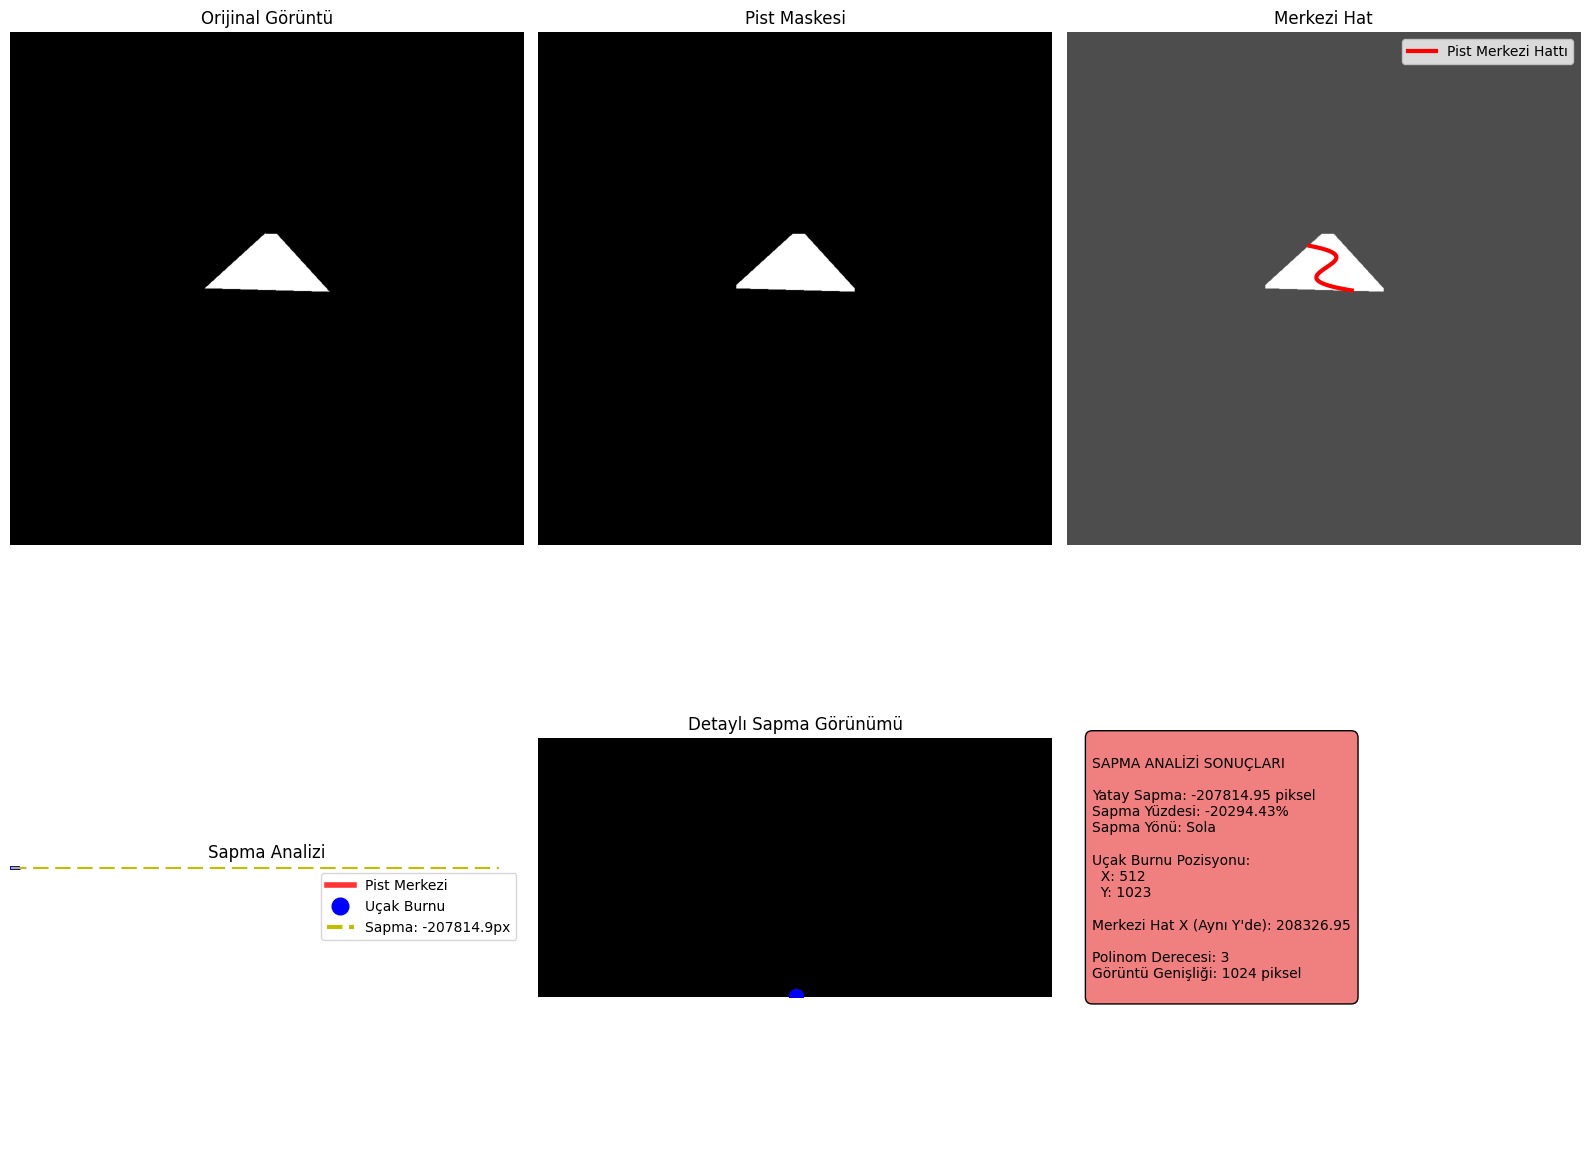


İNİŞ SAPMA ANALİZİ TAMAMLANDI!

DETAYLI SAPMA RAPORU:
Yatay Sapma: -207814.949 piksel
Sapma Yüzdesi: -20294.429%
Sapma Yönü: Sola
Uçak Burnu Pozisyonu: (512, 1023)
Merkezi Hat X Koordinatı: 208326.95
🔴 DEĞERLENDİRME: Yüksek sapma - dikkat gerekli

Polinom Katsayıları: [ 1.22734367e-03 -1.72704164e+00  8.08571074e+02 -1.25435218e+05]
Merkezi Hat Nokta Sayısı: 837


In [19]:
import cv2
import numpy as np
from scipy import ndimage
from skimage import morphology, measure
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import os

class AircraftLandingAnalyzer:
    def __init__(self):
        self.centerline_coords = None
        self.runway_mask = None
        self.polynomial_coeffs = None
        self.aircraft_nose_point = None
        self.image_center = None

    def preprocess_image(self, image_path):
        """Görüntüyü ön işleme"""
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Görüntü dosyası bulunamadı: {image_path}")

        # Görüntüyü yükle
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError("Görüntü yüklenemedi")

        # Gri tonlamaya çevir
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Gaussian blur uygula
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)

        # Görüntü merkezini hesapla (uçak burnu referansı)
        height, width = gray.shape
        self.image_center = (width // 2, height)  # Alt orta nokta (uçak burnu pozisyonu)

        return image, gray, blurred

    def extract_runway(self, gray_image):
        """Pisti segmentasyon ile ayır"""
        # Otsu threshold
        _, binary = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Morfolojik işlemler
        kernel = np.ones((7, 7), np.uint8)
        cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, kernel)

        # En büyük bağlı bileşeni bul (pist olarak kabul et)
        contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            runway_mask = np.zeros_like(gray_image)
            cv2.fillPoly(runway_mask, [largest_contour], 255)
        else:
            runway_mask = cleaned

        self.runway_mask = runway_mask
        return runway_mask

    def find_centerline_skeleton(self, runway_mask):
        """Skeleton tabanlı merkezi hat bulma"""
        # Distance transform
        dist_transform = cv2.distanceTransform(runway_mask, cv2.DIST_L2, 5)

        # Skeletonization
        skeleton = morphology.skeletonize(runway_mask > 0)

        # Skeleton üzerindeki noktaları bul
        skeleton_points = np.column_stack(np.where(skeleton))

        if len(skeleton_points) == 0:
            return None

        # Y koordinatına göre sırala (yukarıdan aşağıya)
        skeleton_points = skeleton_points[np.argsort(skeleton_points[:, 0])]

        return skeleton_points

    def fit_polynomial_centerline(self, skeleton_points, degree=3):
        """Polinom ile merkezi hattı modelle"""
        if skeleton_points is None or len(skeleton_points) < degree + 1:
            return None

        # X ve Y koordinatları
        y_coords = skeleton_points[:, 0]  # Satır (Y)
        x_coords = skeleton_points[:, 1]  # Sütun (X)

        # Polinom fit
        try:
            coeffs = np.polyfit(y_coords, x_coords, degree)
            self.polynomial_coeffs = coeffs

            # Düzgün bir merkezi hat oluştur
            y_range = np.linspace(y_coords.min(), y_coords.max(),
                                len(skeleton_points) * 3)
            x_fitted = np.polyval(coeffs, y_range)

            centerline = np.column_stack([y_range, x_fitted])
            self.centerline_coords = centerline

            return centerline
        except np.RankWarning:
            print("Polinom fit uyarısı - düşük dereceli polinom kullanılıyor")
            return None

    def calculate_aircraft_nose_position(self, method='image_bottom'):
        """Uçak burnunun pozisyonunu hesapla"""
        height, width = self.runway_mask.shape

        if method == 'image_bottom':
            # Görüntünün alt orta noktasını uçak burnu olarak kabul et
            self.aircraft_nose_point = np.array([height - 1, width // 2])

        elif method == 'runway_bottom':
            # Pistin en alt noktasının ortasını bul
            runway_points = np.column_stack(np.where(self.runway_mask > 0))
            if len(runway_points) > 0:
                bottom_y = np.max(runway_points[:, 0])
                bottom_points = runway_points[runway_points[:, 0] == bottom_y]
                center_x = np.mean(bottom_points[:, 1])
                self.aircraft_nose_point = np.array([bottom_y, center_x])
            else:
                self.aircraft_nose_point = np.array([height - 1, width // 2])

        elif method == 'user_click':
            # Kullanıcının tıklayacağı nokta (interaktif)
            print("Lütfen uçak burnunu işaretlemek için görüntüye tıklayın...")
            # Bu method için ayrı bir fonksiyon gerekecek
            pass

        return self.aircraft_nose_point

    def calculate_deviation_from_centerline(self):
        """Uçak burnu ile merkezi hat arasındaki sapmayı hesapla"""
        if self.centerline_coords is None or self.aircraft_nose_point is None:
            return None

        # Uçak burnunun Y koordinatında merkezi hattın X koordinatını bul
        nose_y = self.aircraft_nose_point[0]
        nose_x = self.aircraft_nose_point[1]

        # Polinom kullanarak bu Y koordinatındaki merkezi hat X koordinatını hesapla
        if self.polynomial_coeffs is not None:
            centerline_x_at_nose_y = np.polyval(self.polynomial_coeffs, nose_y)
        else:
            # En yakın merkezi hat noktasını bul
            distances = np.sqrt(np.sum((self.centerline_coords - self.aircraft_nose_point) ** 2, axis=1))
            closest_idx = np.argmin(distances)
            centerline_x_at_nose_y = self.centerline_coords[closest_idx, 1]

        # Yatay sapma (piksel cinsinden)
        horizontal_deviation = nose_x - centerline_x_at_nose_y

        # Görüntü genişliğine göre normalize et (yüzde olarak)
        image_width = self.runway_mask.shape[1]
        deviation_percentage = (horizontal_deviation / image_width) * 100

        # İstatistikler
        deviation_stats = {
            'horizontal_deviation_pixels': horizontal_deviation,
            'deviation_percentage': deviation_percentage,
            'aircraft_nose_position': self.aircraft_nose_point,
            'centerline_x_at_nose': centerline_x_at_nose_y,
            'image_width': image_width,
            'deviation_direction': 'Sağa' if horizontal_deviation > 0 else 'Sola' if horizontal_deviation < 0 else 'Merkez'
        }

        return deviation_stats

    def find_runway_edges(self):
        """Pist kenarlarını bul (referans için)"""
        if self.runway_mask is None:
            return None

        # Pist maskesinin kenarlarını bul
        edges = cv2.Canny(self.runway_mask, 50, 150)

        # Hough Line Transform ile çizgileri bul
        lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50,
                               minLineLength=100, maxLineGap=20)

        return lines

    def interactive_nose_selection(self, image):
        """Kullanıcının uçak burnunu seçmesi için interaktif fonksiyon"""
        self.selected_point = None

        def mouse_callback(event, x, y, flags, param):
            if event == cv2.EVENT_LBUTTONDOWN:
                self.selected_point = np.array([y, x])  # Y, X formatında
                cv2.circle(image, (x, y), 5, (0, 255, 0), -1)
                cv2.imshow('Uçak Burnunu Seçin', image)

        cv2.imshow('Uçak Burnunu Seçin', image)
        cv2.setMouseCallback('Uçak Burnunu Seçin', mouse_callback)

        print("Uçak burnunu işaretlemek için görüntüye tıklayın, ardından herhangi bir tuşa basın...")
        cv2.waitKey(0)
        cv2.destroyAllWindows()

        if self.selected_point is not None:
            self.aircraft_nose_point = self.selected_point

        return self.selected_point

    def visualize_results(self, original_image, save_path=None):
        """Sonuçları görselleştir"""
        plt.figure(figsize=(16, 12))

        # Orijinal görüntü
        plt.subplot(2, 3, 1)
        plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
        plt.title('Orijinal Görüntü')
        plt.axis('off')

        # Pist maskesi
        plt.subplot(2, 3, 2)
        plt.imshow(self.runway_mask, cmap='gray')
        plt.title('Pist Maskesi')
        plt.axis('off')

        # Merkezi hat
        plt.subplot(2, 3, 3)
        plt.imshow(self.runway_mask, cmap='gray', alpha=0.7)
        if self.centerline_coords is not None:
            plt.plot(self.centerline_coords[:, 1], self.centerline_coords[:, 0],
                    'r-', linewidth=3, label='Pist Merkezi Hattı')
        plt.title('Merkezi Hat')
        plt.legend()
        plt.axis('off')

        # Sapma analizi - ana görünüm
        plt.subplot(2, 3, 4)
        combined = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        plt.imshow(combined)

        # Merkezi hattı çiz
        if self.centerline_coords is not None:
            plt.plot(self.centerline_coords[:, 1], self.centerline_coords[:, 0],
                    'r-', linewidth=4, label='Pist Merkezi', alpha=0.8)

        # Uçak burnunu işaretle
        if self.aircraft_nose_point is not None:
            plt.plot(self.aircraft_nose_point[1], self.aircraft_nose_point[0],
                    'bo', markersize=12, label='Uçak Burnu')

            # Sapma çizgisini çiz
            deviation_stats = self.calculate_deviation_from_centerline()
            if deviation_stats:
                centerline_x = deviation_stats['centerline_x_at_nose']
                nose_y = self.aircraft_nose_point[0]

                # Yatay sapma çizgisi
                plt.plot([self.aircraft_nose_point[1], centerline_x],
                        [nose_y, nose_y],
                        'y--', linewidth=3, label=f'Sapma: {deviation_stats["horizontal_deviation_pixels"]:.1f}px')

        plt.title('Sapma Analizi')
        plt.legend()
        plt.axis('off')

        # Detaylı sapma görünümü
        plt.subplot(2, 3, 5)
        if self.aircraft_nose_point is not None and self.centerline_coords is not None:
            # Sadece uçak burnu çevresini göster
            nose_y, nose_x = self.aircraft_nose_point
            crop_size = 100

            y_start = max(0, int(nose_y - crop_size))
            y_end = min(original_image.shape[0], int(nose_y + crop_size//2))
            x_start = max(0, int(nose_x - crop_size))
            x_end = min(original_image.shape[1], int(nose_x + crop_size))

            cropped = original_image[y_start:y_end, x_start:x_end]
            plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))

            # Kırpılmış görüntüde koordinatları ayarla
            adjusted_nose_x = nose_x - x_start
            adjusted_nose_y = nose_y - y_start

            # Merkezi hattı kırpılmış alanda çiz
            mask = ((self.centerline_coords[:, 0] >= y_start) &
                   (self.centerline_coords[:, 0] <= y_end) &
                   (self.centerline_coords[:, 1] >= x_start) &
                   (self.centerline_coords[:, 1] <= x_end))

            if np.any(mask):
                cropped_centerline = self.centerline_coords[mask]
                plt.plot(cropped_centerline[:, 1] - x_start,
                        cropped_centerline[:, 0] - y_start,
                        'r-', linewidth=3)

            plt.plot(adjusted_nose_x, adjusted_nose_y, 'bo', markersize=10)
            plt.title('Detaylı Sapma Görünümü')
        else:
            plt.text(0.5, 0.5, 'Detay mevcut değil', ha='center', va='center')
            plt.title('Detaylı Görünüm')
        plt.axis('off')

        # İstatistikler
        plt.subplot(2, 3, 6)
        plt.axis('off')
        deviation_stats = self.calculate_deviation_from_centerline()
        if deviation_stats:
            stats_text = f"""
SAPMA ANALİZİ SONUÇLARI

Yatay Sapma: {deviation_stats['horizontal_deviation_pixels']:.2f} piksel
Sapma Yüzdesi: {deviation_stats['deviation_percentage']:.2f}%
Sapma Yönü: {deviation_stats['deviation_direction']}

Uçak Burnu Pozisyonu:
  X: {deviation_stats['aircraft_nose_position'][1]:.0f}
  Y: {deviation_stats['aircraft_nose_position'][0]:.0f}

Merkezi Hat X (Aynı Y'de): {deviation_stats['centerline_x_at_nose']:.2f}

Polinom Derecesi: {len(self.polynomial_coeffs)-1 if self.polynomial_coeffs is not None else 'N/A'}
Görüntü Genişliği: {deviation_stats['image_width']} piksel
            """

            # Sapma seviyesine göre renk
            if abs(deviation_stats['deviation_percentage']) < 2:
                bg_color = "lightgreen"
            elif abs(deviation_stats['deviation_percentage']) < 5:
                bg_color = "lightyellow"
            else:
                bg_color = "lightcoral"

            plt.text(0.05, 0.5, stats_text, fontsize=10, verticalalignment='center',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor=bg_color))

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Sonuçlar kaydedildi: {save_path}")

        plt.show()

    def process_landing_analysis(self, image_path, nose_method='image_bottom',
                               poly_degree=3, save_results=True, interactive=False):
        """Ana analiz fonksiyonu"""
        try:
            print("İniş sapma analizi başlatılıyor...")

            # Görüntüyü yükle ve ön işle
            original, gray, blurred = self.preprocess_image(image_path)
            print("✓ Görüntü yüklendi ve ön işleme tamamlandı")

            # Pisti çıkar
            runway_mask = self.extract_runway(blurred)
            print("✓ Pist segmentasyonu tamamlandı")

            # Merkezi hattı bul
            skeleton_points = self.find_centerline_skeleton(runway_mask)
            if skeleton_points is not None:
                centerline = self.fit_polynomial_centerline(skeleton_points, poly_degree)
                print(f"✓ Merkezi hat bulundu (Polinom derecesi: {poly_degree})")
            else:
                print("✗ Merkezi hat bulunamadı")
                return None

            # Uçak burnunu belirle
            if interactive:
                self.interactive_nose_selection(original.copy())
                print("✓ Uçak burnu interaktif olarak seçildi")
            else:
                self.calculate_aircraft_nose_position(nose_method)
                print(f"✓ Uçak burnu pozisyonu hesaplandı ({nose_method})")

            # Sapmayı hesapla
            deviation_stats = self.calculate_deviation_from_centerline()
            if deviation_stats:
                print("✓ Sapma analizi tamamlandı")
                print(f"  - Yatay sapma: {deviation_stats['horizontal_deviation_pixels']:.2f} piksel")
                print(f"  - Sapma yüzdesi: {deviation_stats['deviation_percentage']:.2f}%")
                print(f"  - Yön: {deviation_stats['deviation_direction']}")
            else:
                print("✗ Sapma analizi yapılamadı")

            # Sonuçları görselleştir
            if save_results:
                save_path = image_path.replace('.', '_landing_analysis.')
                self.visualize_results(original, save_path)
            else:
                self.visualize_results(original)

            return {
                'centerline': self.centerline_coords,
                'polynomial_coeffs': self.polynomial_coeffs,
                'deviation_stats': deviation_stats,
                'runway_mask': self.runway_mask,
                'aircraft_nose': self.aircraft_nose_point
            }

        except Exception as e:
            print(f"Hata oluştu: {str(e)}")
            return None

# Kullanım örneği
if __name__ == "__main__":
    # Analyzer oluştur
    analyzer = AircraftLandingAnalyzer()

    # Görüntü yolunu belirtin
    image_path = "/content/drive/MyDrive/runway_detection_and_tracking/split_dataset/MASK_PNG/17MUtbOfdNQ_103__night_4.mask.png"  # Kendi görüntü yolunuzu yazın

    print("İniş Sapma Analizi Seçenekleri:")
    print("1. Otomatik (görüntü alt merkezi)")
    print("2. Pist tabanlı (pist alt merkezi)")
    print("3. İnteraktif (manuel seçim)")

    choice = input("Seçiminizi yapın (1-3): ").strip()

    if choice == "1":
        method = 'image_bottom'
        interactive = False
    elif choice == "2":
        method = 'runway_bottom'
        interactive = False
    elif choice == "3":
        method = 'image_bottom'  # Default, ama interactive=True
        interactive = True
    else:
        method = 'image_bottom'
        interactive = False

    # Analizi çalıştır
    results = analyzer.process_landing_analysis(
        image_path=image_path,
        nose_method=method,
        poly_degree=3,
        save_results=True,
        interactive=interactive
    )

    if results:
        print("\n" + "="*60)
        print("İNİŞ SAPMA ANALİZİ TAMAMLANDI!")
        print("="*60)

        # Detaylı sonuçları yazdır
        if results['deviation_stats']:
            stats = results['deviation_stats']
            print(f"\nDETAYLI SAPMA RAPORU:")
            print(f"Yatay Sapma: {stats['horizontal_deviation_pixels']:.3f} piksel")
            print(f"Sapma Yüzdesi: {stats['deviation_percentage']:.3f}%")
            print(f"Sapma Yönü: {stats['deviation_direction']}")
            print(f"Uçak Burnu Pozisyonu: ({stats['aircraft_nose_position'][1]:.0f}, {stats['aircraft_nose_position'][0]:.0f})")
            print(f"Merkezi Hat X Koordinatı: {stats['centerline_x_at_nose']:.2f}")

            # Sapma değerlendirmesi
            if abs(stats['deviation_percentage']) < 1:
                print("🟢 DEĞERLENDİRME: Mükemmel hizalama")
            elif abs(stats['deviation_percentage']) < 3:
                print("🟡 DEĞERLENDİRME: İyi hizalama")
            elif abs(stats['deviation_percentage']) < 5:
                print("🟠 DEĞERLENDİRME: Kabul edilebilir sapma")
            else:
                print("🔴 DEĞERLENDİRME: Yüksek sapma - dikkat gerekli")

        print(f"\nPolinom Katsayıları: {results['polynomial_coeffs']}")
        print(f"Merkezi Hat Nokta Sayısı: {len(results['centerline']) if results['centerline'] is not None else 0}")
    else:
        print("❌ Analiz başarısız oldu!")